# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in TensorFlow.  For example, suppose we are building a biological reinforcement learning model, but we'd like the inputs to our model to be natural images rather than artificial vectors.  We could load a vision network from TensorFlow, insert it into our model using NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the [TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to write code directly in TensorFlow, and then insert it easily into Nengo.  In this example we will demonstrate how to integrate a Keras network into a Nengo model in a series of stages. First, inserting an entire Keras model, second, inserting individual Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the node to insert Python code into our model we will use it to insert TensorFlow code.  

The first thing we need to do is define our TensorNode output.  This is a function that accepts the current simulation time (and, optionally, a batch of vectors) as input, and produces a batch of vectors as output.  All of these variables will be represented as `tf.Tensor` objects, and the internal operations of the TensorNode will be implemented with TensorFlow operations. For example, we could use a TensorNode to output a `sin` function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

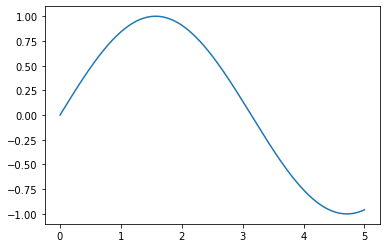

In [2]:
with nengo.Network() as net:
    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)
        
        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))
        
        return output
    
    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)
    
plt.figure()
plt.plot(sim.trange(), sim.data[p]);

However, outputting a `sin` function is something we could do more easily with a regular `nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more complex TensorFlow code and insert it into a NengoDL model. For example, one thing we often want to do is take a deep network written in TensorFlow/Keras, and add it into a Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate) is a popular software package for building and training deep learning style networks.  It is a higher-level API within TensorFlow to make it easier to construct and train deep networks.  And because it is all implemented as a TensorFlow network under the hood, we can define a network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the [introduction in the Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.  This dataset contains images of clothing, and the goal of the network is to identify what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

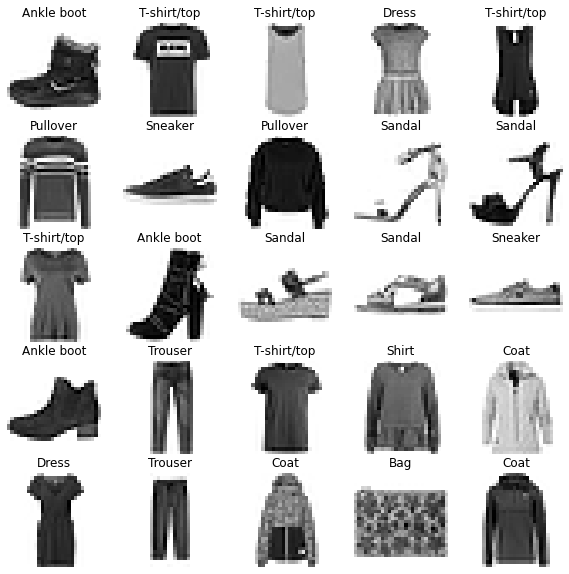

In [3]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.fashion_mnist.load_data())

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Epoch 1/5


   1/1875 [..............................] - ETA: 0s - loss: 2.2751 - accuracy: 0.0938

  35/1875 [..............................] - ETA: 2s - loss: 1.2775 - accuracy: 0.5607

  71/1875 [>.............................] - ETA: 2s - loss: 1.0380 - accuracy: 0.6316

 105/1875 [>.............................] - ETA: 2s - loss: 0.9148 - accuracy: 0.6789

 140/1875 [=>............................] - ETA: 2s - loss: 0.8432 - accuracy: 0.7025

 174/1875 [=>............................] - ETA: 2s - loss: 0.7973 - accuracy: 0.7196

 209/1875 [==>...........................] - ETA: 2s - loss: 0.7680 - accuracy: 0.7291

 243/1875 [==>...........................] - ETA: 2s - loss: 0.7397 - accuracy: 0.7407

 273/1875 [===>..........................] - ETA: 2s - loss: 0.7165 - accuracy: 0.7500

 308/1875 [===>..........................] - ETA: 2s - loss: 0.6972 - accuracy: 0.7551

 341/1875 [====>.........................] - ETA: 2s - loss: 0.6849 - accuracy: 0.7591

 376/1875 [=====>........................] - ETA: 2s - loss: 0.6736 - accuracy: 0.7630

 411/1875 [=====>........................] - ETA: 2s - loss: 0.6610 - accuracy: 0.7682

 447/1875 [======>.......................] - ETA: 2s - loss: 0.6499 - accuracy: 0.7721

 480/1875 [======>.......................] - ETA: 2s - loss: 0.6396 - accuracy: 0.7761

 514/1875 [=======>......................] - ETA: 2s - loss: 0.6335 - accuracy: 0.7778

 541/1875 [=======>......................] - ETA: 2s - loss: 0.6267 - accuracy: 0.7805

 577/1875 [========>.....................] - ETA: 1s - loss: 0.6208 - accuracy: 0.7828

 610/1875 [========>.....................] - ETA: 1s - loss: 0.6135 - accuracy: 0.7845

 644/1875 [=========>....................] - ETA: 1s - loss: 0.6083 - accuracy: 0.7870

 675/1875 [=========>....................] - ETA: 1s - loss: 0.6014 - accuracy: 0.7899

 708/1875 [==========>...................] - ETA: 1s - loss: 0.5957 - accuracy: 0.7919

 743/1875 [==========>...................] - ETA: 1s - loss: 0.5895 - accuracy: 0.7937

 778/1875 [===========>..................] - ETA: 1s - loss: 0.5850 - accuracy: 0.7943

 812/1875 [===========>..................] - ETA: 1s - loss: 0.5797 - accuracy: 0.7961

 847/1875 [============>.................] - ETA: 1s - loss: 0.5776 - accuracy: 0.7966

 882/1875 [=============>................] - ETA: 1s - loss: 0.5736 - accuracy: 0.7983

 916/1875 [=============>................] - ETA: 1s - loss: 0.5676 - accuracy: 0.8007

 949/1875 [==============>...............] - ETA: 1s - loss: 0.5634 - accuracy: 0.8025

 983/1875 [==============>...............] - ETA: 1s - loss: 0.5591 - accuracy: 0.8038

1018/1875 [===============>..............] - ETA: 1s - loss: 0.5551 - accuracy: 0.8053

1054/1875 [===============>..............] - ETA: 1s - loss: 0.5521 - accuracy: 0.8064

1088/1875 [================>.............] - ETA: 1s - loss: 0.5484 - accuracy: 0.8076

1122/1875 [================>.............] - ETA: 1s - loss: 0.5453 - accuracy: 0.8086

1157/1875 [=================>............] - ETA: 1s - loss: 0.5422 - accuracy: 0.8097



1192/1875 [==================>...........] - ETA: 1s - loss: 0.5383 - accuracy: 0.8110

1226/1875 [==================>...........] - ETA: 0s - loss: 0.5356 - accuracy: 0.8117

1260/1875 [===================>..........] - ETA: 0s - loss: 0.5331 - accuracy: 0.8128

1294/1875 [===================>..........] - ETA: 0s - loss: 0.5314 - accuracy: 0.8136

1329/1875 [====================>.........] - ETA: 0s - loss: 0.5288 - accuracy: 0.8146

1360/1875 [====================>.........] - ETA: 0s - loss: 0.5269 - accuracy: 0.8152

1389/1875 [=====================>........] - ETA: 0s - loss: 0.5247 - accuracy: 0.8161

1424/1875 [=====================>........] - ETA: 0s - loss: 0.5215 - accuracy: 0.8169

1458/1875 [======================>.......] - ETA: 0s - loss: 0.5192 - accuracy: 0.8178

1489/1875 [======================>.......] - ETA: 0s - loss: 0.5167 - accuracy: 0.8186

1524/1875 [=======================>......] - ETA: 0s - loss: 0.5148 - accuracy: 0.8194

1559/1875 [=======================>......] - ETA: 0s - loss: 0.5137 - accuracy: 0.8197

1594/1875 [========================>.....] - ETA: 0s - loss: 0.5125 - accuracy: 0.8201

1628/1875 [=========================>....] - ETA: 0s - loss: 0.5108 - accuracy: 0.8206

1660/1875 [=========================>....] - ETA: 0s - loss: 0.5085 - accuracy: 0.8215

1695/1875 [==========================>...] - ETA: 0s - loss: 0.5073 - accuracy: 0.8219

1729/1875 [==========================>...] - ETA: 0s - loss: 0.5056 - accuracy: 0.8225

1765/1875 [===========================>..] - ETA: 0s - loss: 0.5029 - accuracy: 0.8235

1800/1875 [===========================>..] - ETA: 0s - loss: 0.5017 - accuracy: 0.8238

1836/1875 [============================>.] - ETA: 0s - loss: 0.5002 - accuracy: 0.8246

1871/1875 [============================>.] - ETA: 0s - loss: 0.4995 - accuracy: 0.8246

1875/1875 [==============================] - 3s 1ms/step - loss: 0.4992 - accuracy: 0.8246


Epoch 2/5
   1/1875 [..............................] - ETA: 0s - loss: 0.1635 - accuracy: 0.9688

  37/1875 [..............................] - ETA: 2s - loss: 0.3749 - accuracy: 0.8733

  72/1875 [>.............................] - ETA: 2s - loss: 0.3689 - accuracy: 0.8715

 105/1875 [>.............................] - ETA: 2s - loss: 0.3890 - accuracy: 0.8661

 141/1875 [=>............................] - ETA: 2s - loss: 0.3921 - accuracy: 0.8615

 175/1875 [=>............................] - ETA: 2s - loss: 0.3970 - accuracy: 0.8582

 209/1875 [==>...........................] - ETA: 2s - loss: 0.3906 - accuracy: 0.8612

 244/1875 [==>...........................] - ETA: 2s - loss: 0.3897 - accuracy: 0.8609

 279/1875 [===>..........................] - ETA: 2s - loss: 0.3956 - accuracy: 0.8579

 314/1875 [====>.........................] - ETA: 2s - loss: 0.3981 - accuracy: 0.8575

 348/1875 [====>.........................] - ETA: 2s - loss: 0.3943 - accuracy: 0.8587

 384/1875 [=====>........................] - ETA: 2s - loss: 0.3897 - accuracy: 0.8590

 418/1875 [=====>........................] - ETA: 2s - loss: 0.3877 - accuracy: 0.8589

 453/1875 [======>.......................] - ETA: 2s - loss: 0.3865 - accuracy: 0.8593

 488/1875 [======>.......................] - ETA: 2s - loss: 0.3859 - accuracy: 0.8598

 523/1875 [=======>......................] - ETA: 1s - loss: 0.3869 - accuracy: 0.8598

 557/1875 [=======>......................] - ETA: 1s - loss: 0.3861 - accuracy: 0.8600

 592/1875 [========>.....................] - ETA: 1s - loss: 0.3858 - accuracy: 0.8594

 628/1875 [=========>....................] - ETA: 1s - loss: 0.3851 - accuracy: 0.8599

 663/1875 [=========>....................] - ETA: 1s - loss: 0.3870 - accuracy: 0.8588

 696/1875 [==========>...................] - ETA: 1s - loss: 0.3849 - accuracy: 0.8593

 731/1875 [==========>...................] - ETA: 1s - loss: 0.3868 - accuracy: 0.8587

 766/1875 [===========>..................] - ETA: 1s - loss: 0.3865 - accuracy: 0.8590

 800/1875 [===========>..................] - ETA: 1s - loss: 0.3873 - accuracy: 0.8587

 834/1875 [============>.................] - ETA: 1s - loss: 0.3858 - accuracy: 0.8592

 869/1875 [============>.................] - ETA: 1s - loss: 0.3830 - accuracy: 0.8612

 903/1875 [=============>................] - ETA: 1s - loss: 0.3835 - accuracy: 0.8614

 935/1875 [=============>................] - ETA: 1s - loss: 0.3828 - accuracy: 0.8614

 970/1875 [==============>...............] - ETA: 1s - loss: 0.3822 - accuracy: 0.8613

1006/1875 [===============>..............] - ETA: 1s - loss: 0.3824 - accuracy: 0.8611

1041/1875 [===============>..............] - ETA: 1s - loss: 0.3808 - accuracy: 0.8614

1076/1875 [================>.............] - ETA: 1s - loss: 0.3806 - accuracy: 0.8616

1110/1875 [================>.............] - ETA: 1s - loss: 0.3790 - accuracy: 0.8624

1143/1875 [=================>............] - ETA: 1s - loss: 0.3780 - accuracy: 0.8627

1176/1875 [=================>............] - ETA: 1s - loss: 0.3786 - accuracy: 0.8626

1208/1875 [==================>...........] - ETA: 0s - loss: 0.3785 - accuracy: 0.8628

1232/1875 [==================>...........] - ETA: 0s - loss: 0.3787 - accuracy: 0.8627

1262/1875 [===================>..........] - ETA: 0s - loss: 0.3790 - accuracy: 0.8627

1292/1875 [===================>..........] - ETA: 0s - loss: 0.3798 - accuracy: 0.8622

1324/1875 [====================>.........] - ETA: 0s - loss: 0.3806 - accuracy: 0.8618

1358/1875 [====================>.........] - ETA: 0s - loss: 0.3802 - accuracy: 0.8620

1391/1875 [=====================>........] - ETA: 0s - loss: 0.3797 - accuracy: 0.8621

1424/1875 [=====================>........] - ETA: 0s - loss: 0.3787 - accuracy: 0.8626

1458/1875 [======================>.......] - ETA: 0s - loss: 0.3794 - accuracy: 0.8626

1492/1875 [======================>.......] - ETA: 0s - loss: 0.3792 - accuracy: 0.8627

1524/1875 [=======================>......] - ETA: 0s - loss: 0.3791 - accuracy: 0.8628

1557/1875 [=======================>......] - ETA: 0s - loss: 0.3794 - accuracy: 0.8628

1590/1875 [========================>.....] - ETA: 0s - loss: 0.3799 - accuracy: 0.8628

1624/1875 [========================>.....] - ETA: 0s - loss: 0.3792 - accuracy: 0.8630

1656/1875 [=========================>....] - ETA: 0s - loss: 0.3784 - accuracy: 0.8631

1689/1875 [==========================>...] - ETA: 0s - loss: 0.3782 - accuracy: 0.8634

1724/1875 [==========================>...] - ETA: 0s - loss: 0.3779 - accuracy: 0.8634

1752/1875 [===========================>..] - ETA: 0s - loss: 0.3780 - accuracy: 0.8634

1786/1875 [===========================>..] - ETA: 0s - loss: 0.3772 - accuracy: 0.8637

1820/1875 [============================>.] - ETA: 0s - loss: 0.3771 - accuracy: 0.8638

1855/1875 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.8644

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3758 - accuracy: 0.8644


Epoch 3/5
   1/1875 [..............................] - ETA: 0s - loss: 0.4776 - accuracy: 0.8438

  34/1875 [..............................] - ETA: 2s - loss: 0.3419 - accuracy: 0.8667

  68/1875 [>.............................] - ETA: 2s - loss: 0.3549 - accuracy: 0.8653

 103/1875 [>.............................] - ETA: 2s - loss: 0.3472 - accuracy: 0.8686

 137/1875 [=>............................] - ETA: 2s - loss: 0.3448 - accuracy: 0.8702

 162/1875 [=>............................] - ETA: 2s - loss: 0.3439 - accuracy: 0.8713

 195/1875 [==>...........................] - ETA: 2s - loss: 0.3377 - accuracy: 0.8744

 229/1875 [==>...........................] - ETA: 2s - loss: 0.3322 - accuracy: 0.8769

 263/1875 [===>..........................] - ETA: 2s - loss: 0.3343 - accuracy: 0.8757

 296/1875 [===>..........................] - ETA: 2s - loss: 0.3348 - accuracy: 0.8758

 330/1875 [====>.........................] - ETA: 2s - loss: 0.3339 - accuracy: 0.8761

 360/1875 [====>.........................] - ETA: 2s - loss: 0.3327 - accuracy: 0.8766

 393/1875 [=====>........................] - ETA: 2s - loss: 0.3324 - accuracy: 0.8767

 423/1875 [=====>........................] - ETA: 2s - loss: 0.3337 - accuracy: 0.8760

 457/1875 [======>.......................] - ETA: 2s - loss: 0.3352 - accuracy: 0.8761

 491/1875 [======>.......................] - ETA: 2s - loss: 0.3357 - accuracy: 0.8756

 523/1875 [=======>......................] - ETA: 2s - loss: 0.3385 - accuracy: 0.8749

 555/1875 [=======>......................] - ETA: 2s - loss: 0.3389 - accuracy: 0.8752



 589/1875 [========>.....................] - ETA: 1s - loss: 0.3370 - accuracy: 0.8762

 622/1875 [========>.....................] - ETA: 1s - loss: 0.3368 - accuracy: 0.8761

 656/1875 [=========>....................] - ETA: 1s - loss: 0.3384 - accuracy: 0.8759

 689/1875 [==========>...................] - ETA: 1s - loss: 0.3388 - accuracy: 0.8753

 722/1875 [==========>...................] - ETA: 1s - loss: 0.3389 - accuracy: 0.8751

 756/1875 [===========>..................] - ETA: 1s - loss: 0.3398 - accuracy: 0.8743

 785/1875 [===========>..................] - ETA: 1s - loss: 0.3406 - accuracy: 0.8743

 818/1875 [============>.................] - ETA: 1s - loss: 0.3412 - accuracy: 0.8739

 852/1875 [============>.................] - ETA: 1s - loss: 0.3405 - accuracy: 0.8740

 887/1875 [=============>................] - ETA: 1s - loss: 0.3394 - accuracy: 0.8747

 920/1875 [=============>................] - ETA: 1s - loss: 0.3382 - accuracy: 0.8753

 953/1875 [==============>...............] - ETA: 1s - loss: 0.3374 - accuracy: 0.8753

 987/1875 [==============>...............] - ETA: 1s - loss: 0.3380 - accuracy: 0.8751

1014/1875 [===============>..............] - ETA: 1s - loss: 0.3374 - accuracy: 0.8753

1047/1875 [===============>..............] - ETA: 1s - loss: 0.3382 - accuracy: 0.8754

1077/1875 [================>.............] - ETA: 1s - loss: 0.3374 - accuracy: 0.8756

1111/1875 [================>.............] - ETA: 1s - loss: 0.3371 - accuracy: 0.8756

1145/1875 [=================>............] - ETA: 1s - loss: 0.3369 - accuracy: 0.8760

1176/1875 [=================>............] - ETA: 1s - loss: 0.3373 - accuracy: 0.8757

1210/1875 [==================>...........] - ETA: 1s - loss: 0.3360 - accuracy: 0.8763

1244/1875 [==================>...........] - ETA: 0s - loss: 0.3353 - accuracy: 0.8768

1276/1875 [===================>..........] - ETA: 0s - loss: 0.3353 - accuracy: 0.8765

1308/1875 [===================>..........] - ETA: 0s - loss: 0.3344 - accuracy: 0.8768

1340/1875 [====================>.........] - ETA: 0s - loss: 0.3342 - accuracy: 0.8770

1374/1875 [====================>.........] - ETA: 0s - loss: 0.3358 - accuracy: 0.8765

1408/1875 [=====================>........] - ETA: 0s - loss: 0.3357 - accuracy: 0.8767

1441/1875 [======================>.......] - ETA: 0s - loss: 0.3359 - accuracy: 0.8766

1474/1875 [======================>.......] - ETA: 0s - loss: 0.3359 - accuracy: 0.8765

1506/1875 [=======================>......] - ETA: 0s - loss: 0.3359 - accuracy: 0.8766

1541/1875 [=======================>......] - ETA: 0s - loss: 0.3370 - accuracy: 0.8763

1574/1875 [========================>.....] - ETA: 0s - loss: 0.3375 - accuracy: 0.8761

1608/1875 [========================>.....] - ETA: 0s - loss: 0.3373 - accuracy: 0.8761

1642/1875 [=========================>....] - ETA: 0s - loss: 0.3373 - accuracy: 0.8760

1676/1875 [=========================>....] - ETA: 0s - loss: 0.3373 - accuracy: 0.8760

1707/1875 [==========================>...] - ETA: 0s - loss: 0.3371 - accuracy: 0.8758

1741/1875 [==========================>...] - ETA: 0s - loss: 0.3379 - accuracy: 0.8754

1776/1875 [===========================>..] - ETA: 0s - loss: 0.3370 - accuracy: 0.8759

1810/1875 [===========================>..] - ETA: 0s - loss: 0.3369 - accuracy: 0.8759

1842/1875 [============================>.] - ETA: 0s - loss: 0.3362 - accuracy: 0.8761

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3364 - accuracy: 0.8762


Epoch 4/5
   1/1875 [..............................] - ETA: 0s - loss: 0.1939 - accuracy: 0.9062

  31/1875 [..............................] - ETA: 3s - loss: 0.3277 - accuracy: 0.8639

  58/1875 [..............................] - ETA: 3s - loss: 0.3338 - accuracy: 0.8691

  85/1875 [>.............................] - ETA: 3s - loss: 0.3395 - accuracy: 0.8665

 118/1875 [>.............................] - ETA: 3s - loss: 0.3233 - accuracy: 0.8742

 152/1875 [=>............................] - ETA: 2s - loss: 0.3104 - accuracy: 0.8793

 185/1875 [=>............................] - ETA: 2s - loss: 0.3197 - accuracy: 0.8760

 218/1875 [==>...........................] - ETA: 2s - loss: 0.3138 - accuracy: 0.8794

 253/1875 [===>..........................] - ETA: 2s - loss: 0.3142 - accuracy: 0.8796

 284/1875 [===>..........................] - ETA: 2s - loss: 0.3129 - accuracy: 0.8814

 317/1875 [====>.........................] - ETA: 2s - loss: 0.3141 - accuracy: 0.8821

 349/1875 [====>.........................] - ETA: 2s - loss: 0.3152 - accuracy: 0.8817

 383/1875 [=====>........................] - ETA: 2s - loss: 0.3165 - accuracy: 0.8810

 416/1875 [=====>........................] - ETA: 2s - loss: 0.3164 - accuracy: 0.8814

 449/1875 [======>.......................] - ETA: 2s - loss: 0.3128 - accuracy: 0.8836

 481/1875 [======>.......................] - ETA: 2s - loss: 0.3150 - accuracy: 0.8834

 515/1875 [=======>......................] - ETA: 2s - loss: 0.3135 - accuracy: 0.8835

 550/1875 [=======>......................] - ETA: 2s - loss: 0.3107 - accuracy: 0.8845

 580/1875 [========>.....................] - ETA: 2s - loss: 0.3109 - accuracy: 0.8851

 611/1875 [========>.....................] - ETA: 1s - loss: 0.3115 - accuracy: 0.8845

 646/1875 [=========>....................] - ETA: 1s - loss: 0.3110 - accuracy: 0.8847

 680/1875 [=========>....................] - ETA: 1s - loss: 0.3123 - accuracy: 0.8840

 713/1875 [==========>...................] - ETA: 1s - loss: 0.3116 - accuracy: 0.8842

 745/1875 [==========>...................] - ETA: 1s - loss: 0.3112 - accuracy: 0.8844

 768/1875 [===========>..................] - ETA: 1s - loss: 0.3103 - accuracy: 0.8846

 802/1875 [===========>..................] - ETA: 1s - loss: 0.3092 - accuracy: 0.8852

 835/1875 [============>.................] - ETA: 1s - loss: 0.3068 - accuracy: 0.8866

 867/1875 [============>.................] - ETA: 1s - loss: 0.3089 - accuracy: 0.8855

 894/1875 [=============>................] - ETA: 1s - loss: 0.3077 - accuracy: 0.8858

 924/1875 [=============>................] - ETA: 1s - loss: 0.3082 - accuracy: 0.8859

 955/1875 [==============>...............] - ETA: 1s - loss: 0.3085 - accuracy: 0.8857

 987/1875 [==============>...............] - ETA: 1s - loss: 0.3082 - accuracy: 0.8861



1022/1875 [===============>..............] - ETA: 1s - loss: 0.3096 - accuracy: 0.8861

1055/1875 [===============>..............] - ETA: 1s - loss: 0.3098 - accuracy: 0.8860

1088/1875 [================>.............] - ETA: 1s - loss: 0.3104 - accuracy: 0.8861

1122/1875 [================>.............] - ETA: 1s - loss: 0.3098 - accuracy: 0.8862

1153/1875 [=================>............] - ETA: 1s - loss: 0.3102 - accuracy: 0.8861

1182/1875 [=================>............] - ETA: 1s - loss: 0.3103 - accuracy: 0.8859

1213/1875 [==================>...........] - ETA: 1s - loss: 0.3097 - accuracy: 0.8859

1245/1875 [==================>...........] - ETA: 1s - loss: 0.3102 - accuracy: 0.8857

1279/1875 [===================>..........] - ETA: 0s - loss: 0.3102 - accuracy: 0.8856

1314/1875 [====================>.........] - ETA: 0s - loss: 0.3098 - accuracy: 0.8858

1347/1875 [====================>.........] - ETA: 0s - loss: 0.3095 - accuracy: 0.8861

1381/1875 [=====================>........] - ETA: 0s - loss: 0.3101 - accuracy: 0.8861

1414/1875 [=====================>........] - ETA: 0s - loss: 0.3094 - accuracy: 0.8867

1449/1875 [======================>.......] - ETA: 0s - loss: 0.3098 - accuracy: 0.8864

1482/1875 [======================>.......] - ETA: 0s - loss: 0.3103 - accuracy: 0.8862

1515/1875 [=======================>......] - ETA: 0s - loss: 0.3103 - accuracy: 0.8860

1545/1875 [=======================>......] - ETA: 0s - loss: 0.3103 - accuracy: 0.8858

1579/1875 [========================>.....] - ETA: 0s - loss: 0.3103 - accuracy: 0.8857

1611/1875 [========================>.....] - ETA: 0s - loss: 0.3108 - accuracy: 0.8856

1644/1875 [=========================>....] - ETA: 0s - loss: 0.3107 - accuracy: 0.8858

1676/1875 [=========================>....] - ETA: 0s - loss: 0.3101 - accuracy: 0.8861

1710/1875 [==========================>...] - ETA: 0s - loss: 0.3096 - accuracy: 0.8863

1743/1875 [==========================>...] - ETA: 0s - loss: 0.3091 - accuracy: 0.8866

1777/1875 [===========================>..] - ETA: 0s - loss: 0.3098 - accuracy: 0.8865

1812/1875 [===========================>..] - ETA: 0s - loss: 0.3114 - accuracy: 0.8859

1836/1875 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8858

1854/1875 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8857

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3118 - accuracy: 0.8856


Epoch 5/5
   1/1875 [..............................] - ETA: 0s - loss: 0.2307 - accuracy: 0.9375

  36/1875 [..............................] - ETA: 2s - loss: 0.3044 - accuracy: 0.8750

  69/1875 [>.............................] - ETA: 2s - loss: 0.2758 - accuracy: 0.8890

 101/1875 [>.............................] - ETA: 2s - loss: 0.2637 - accuracy: 0.8985

 134/1875 [=>............................] - ETA: 2s - loss: 0.2685 - accuracy: 0.8960

 169/1875 [=>............................] - ETA: 2s - loss: 0.2775 - accuracy: 0.8955

 203/1875 [==>...........................] - ETA: 2s - loss: 0.2820 - accuracy: 0.8944

 235/1875 [==>...........................] - ETA: 2s - loss: 0.2851 - accuracy: 0.8949

 268/1875 [===>..........................] - ETA: 2s - loss: 0.2859 - accuracy: 0.8942

 300/1875 [===>..........................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8938

 332/1875 [====>.........................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8935

 364/1875 [====>.........................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8936

 395/1875 [=====>........................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8945

 430/1875 [=====>........................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8938

 463/1875 [======>.......................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8936

 495/1875 [======>.......................] - ETA: 2s - loss: 0.2865 - accuracy: 0.8941

 527/1875 [=======>......................] - ETA: 2s - loss: 0.2860 - accuracy: 0.8944

 561/1875 [=======>......................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8937

 594/1875 [========>.....................] - ETA: 1s - loss: 0.2906 - accuracy: 0.8933

 626/1875 [=========>....................] - ETA: 1s - loss: 0.2928 - accuracy: 0.8925

 657/1875 [=========>....................] - ETA: 1s - loss: 0.2948 - accuracy: 0.8915

 693/1875 [==========>...................] - ETA: 1s - loss: 0.2936 - accuracy: 0.8922

 728/1875 [==========>...................] - ETA: 1s - loss: 0.2932 - accuracy: 0.8920

 760/1875 [===========>..................] - ETA: 1s - loss: 0.2951 - accuracy: 0.8912

 792/1875 [===========>..................] - ETA: 1s - loss: 0.2943 - accuracy: 0.8915

 825/1875 [============>.................] - ETA: 1s - loss: 0.2935 - accuracy: 0.8918

 848/1875 [============>.................] - ETA: 1s - loss: 0.2933 - accuracy: 0.8917

 881/1875 [=============>................] - ETA: 1s - loss: 0.2930 - accuracy: 0.8919

 912/1875 [=============>................] - ETA: 1s - loss: 0.2943 - accuracy: 0.8911

 947/1875 [==============>...............] - ETA: 1s - loss: 0.2952 - accuracy: 0.8909

 980/1875 [==============>...............] - ETA: 1s - loss: 0.2945 - accuracy: 0.8912

1011/1875 [===============>..............] - ETA: 1s - loss: 0.2945 - accuracy: 0.8909

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2935 - accuracy: 0.8914

1077/1875 [================>.............] - ETA: 1s - loss: 0.2925 - accuracy: 0.8916

1109/1875 [================>.............] - ETA: 1s - loss: 0.2917 - accuracy: 0.8918

1139/1875 [=================>............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8920

1168/1875 [=================>............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8920

1198/1875 [==================>...........] - ETA: 1s - loss: 0.2903 - accuracy: 0.8923

1229/1875 [==================>...........] - ETA: 1s - loss: 0.2918 - accuracy: 0.8917

1261/1875 [===================>..........] - ETA: 0s - loss: 0.2922 - accuracy: 0.8913

1292/1875 [===================>..........] - ETA: 0s - loss: 0.2922 - accuracy: 0.8913

1323/1875 [====================>.........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8917

1355/1875 [====================>.........] - ETA: 0s - loss: 0.2916 - accuracy: 0.8918

1387/1875 [=====================>........] - ETA: 0s - loss: 0.2917 - accuracy: 0.8917

1419/1875 [=====================>........] - ETA: 0s - loss: 0.2926 - accuracy: 0.8915

1450/1875 [======================>.......] - ETA: 0s - loss: 0.2938 - accuracy: 0.8911

1482/1875 [======================>.......] - ETA: 0s - loss: 0.2943 - accuracy: 0.8909

1514/1875 [=======================>......] - ETA: 0s - loss: 0.2951 - accuracy: 0.8905

1546/1875 [=======================>......] - ETA: 0s - loss: 0.2943 - accuracy: 0.8906

1578/1875 [========================>.....] - ETA: 0s - loss: 0.2942 - accuracy: 0.8908

1610/1875 [========================>.....] - ETA: 0s - loss: 0.2939 - accuracy: 0.8911

1641/1875 [=========================>....] - ETA: 0s - loss: 0.2940 - accuracy: 0.8912

1663/1875 [=========================>....] - ETA: 0s - loss: 0.2933 - accuracy: 0.8914

1690/1875 [==========================>...] - ETA: 0s - loss: 0.2938 - accuracy: 0.8913

1715/1875 [==========================>...] - ETA: 0s - loss: 0.2937 - accuracy: 0.8914

1747/1875 [==========================>...] - ETA: 0s - loss: 0.2938 - accuracy: 0.8913

1780/1875 [===========================>..] - ETA: 0s - loss: 0.2935 - accuracy: 0.8915

1812/1875 [===========================>..] - ETA: 0s - loss: 0.2933 - accuracy: 0.8917

1843/1875 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8918

1873/1875 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8916

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2933 - accuracy: 0.8916


Test accuracy: 0.8737000226974487


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more complicated in this case, since we need to load in the model from above and the pretrained weights.  We can accomplish this by creating a custom Keras Layer, which allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This effectively reruns the Keras model definition from above, but because we're calling it within the `build` stage it will be naturally integrated into the NengoDL model that is being built.

The `call` function is where we do the main job of constructing the TensorFlow elements that will implement our node.  It will take TensorFlow Tensors as input and produce a `tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()
        
        self.model = keras_model
        
    def build(self, input_shapes):
        super().build(input_shapes)
        
        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)
        
        # load the weights we saved above
        self.model.load_weights(model_weights)
        
    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)
    
    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28*28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and connect them up to the Keras node (for example, if we wanted to take the classified image labels and use them as input to a spiking neural model).  But to keep things simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##########    Constructing graph: build stage (16%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8737000226974487


We can see that we're getting the same performance in Nengo as we were in Keras, indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to integrate a Keras model into Nengo by inserting the individual layers.  This requires more manual translation work, but it makes it easier to make changes to the model later on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to the TensorNode.  However, we can make this construction process even simpler by using `nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the Keras functional layer API. Under the hood it's doing the same thing (creating TensorNodes and Connections), but it allows us to define the model in a way that looks very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(
        tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(inp)
    out = nengo_dl.Layer(
        tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL this time. Fortunately, the API is essentially the same:

In [11]:
# we'll disable some features we don't need in this example, to improve
# the training speed
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 1s - loss: 2.2471 - probe_loss: 2.2471 - probe_accuracy: 0.1000

  28/3000 [..............................] - ETA: 5s - loss: 1.3777 - probe_loss: 1.3777 - probe_accuracy: 0.5018

  54/3000 [..............................] - ETA: 5s - loss: 1.1555 - probe_loss: 1.1555 - probe_accuracy: 0.5833

  79/3000 [..............................] - ETA: 5s - loss: 1.0431 - probe_loss: 1.0431 - probe_accuracy: 0.6310

 105/3000 [>.............................] - ETA: 5s - loss: 0.9800 - probe_loss: 0.9800 - probe_accuracy: 0.6571

 132/3000 [>.............................] - ETA: 5s - loss: 0.9087 - probe_loss: 0.9087 - probe_accuracy: 0.6780

 160/3000 [>.............................] - ETA: 5s - loss: 0.8667 - probe_loss: 0.8667 - probe_accuracy: 0.6947

 189/3000 [>.............................] - ETA: 5s - loss: 0.8447 - probe_loss: 0.8447 - probe_accuracy: 0.7040

 215/3000 [=>............................] - ETA: 5s - loss: 0.8241 - probe_loss: 0.8241 - probe_accuracy: 0.7116

 244/3000 [=>............................] - ETA: 5s - loss: 0.8018 - probe_loss: 0.8018 - probe_accuracy: 0.7170

 271/3000 [=>............................] - ETA: 5s - loss: 0.7820 - probe_loss: 0.7820 - probe_accuracy: 0.7268

 298/3000 [=>............................] - ETA: 5s - loss: 0.7766 - probe_loss: 0.7766 - probe_accuracy: 0.7314

 325/3000 [==>...........................] - ETA: 5s - loss: 0.7569 - probe_loss: 0.7569 - probe_accuracy: 0.7386

 353/3000 [==>...........................] - ETA: 4s - loss: 0.7435 - probe_loss: 0.7435 - probe_accuracy: 0.7429

 379/3000 [==>...........................] - ETA: 4s - loss: 0.7313 - probe_loss: 0.7313 - probe_accuracy: 0.7470

 405/3000 [===>..........................] - ETA: 4s - loss: 0.7203 - probe_loss: 0.7203 - probe_accuracy: 0.7509

 429/3000 [===>..........................] - ETA: 4s - loss: 0.7115 - probe_loss: 0.7115 - probe_accuracy: 0.7542

 456/3000 [===>..........................] - ETA: 4s - loss: 0.7007 - probe_loss: 0.7007 - probe_accuracy: 0.7577

 483/3000 [===>..........................] - ETA: 4s - loss: 0.6866 - probe_loss: 0.6866 - probe_accuracy: 0.7615

 509/3000 [====>.........................] - ETA: 4s - loss: 0.6806 - probe_loss: 0.6806 - probe_accuracy: 0.7640

 534/3000 [====>.........................] - ETA: 4s - loss: 0.6720 - probe_loss: 0.6720 - probe_accuracy: 0.7680

 559/3000 [====>.........................] - ETA: 4s - loss: 0.6666 - probe_loss: 0.6666 - probe_accuracy: 0.7700

 582/3000 [====>.........................] - ETA: 4s - loss: 0.6621 - probe_loss: 0.6621 - probe_accuracy: 0.7720

 608/3000 [=====>........................] - ETA: 4s - loss: 0.6559 - probe_loss: 0.6559 - probe_accuracy: 0.7743

 634/3000 [=====>........................] - ETA: 4s - loss: 0.6534 - probe_loss: 0.6534 - probe_accuracy: 0.7750

 657/3000 [=====>........................] - ETA: 4s - loss: 0.6503 - probe_loss: 0.6503 - probe_accuracy: 0.7762

 682/3000 [=====>........................] - ETA: 4s - loss: 0.6467 - probe_loss: 0.6467 - probe_accuracy: 0.7773

 710/3000 [======>.......................] - ETA: 4s - loss: 0.6394 - probe_loss: 0.6394 - probe_accuracy: 0.7796

 731/3000 [======>.......................] - ETA: 4s - loss: 0.6353 - probe_loss: 0.6353 - probe_accuracy: 0.7813

 758/3000 [======>.......................] - ETA: 4s - loss: 0.6301 - probe_loss: 0.6301 - probe_accuracy: 0.7834

 780/3000 [======>.......................] - ETA: 4s - loss: 0.6263 - probe_loss: 0.6263 - probe_accuracy: 0.7849

 804/3000 [=======>......................] - ETA: 4s - loss: 0.6225 - probe_loss: 0.6225 - probe_accuracy: 0.7864

 830/3000 [=======>......................] - ETA: 4s - loss: 0.6189 - probe_loss: 0.6189 - probe_accuracy: 0.7880

 858/3000 [=======>......................] - ETA: 4s - loss: 0.6148 - probe_loss: 0.6148 - probe_accuracy: 0.7891

 884/3000 [=======>......................] - ETA: 4s - loss: 0.6126 - probe_loss: 0.6126 - probe_accuracy: 0.7896

 903/3000 [========>.....................] - ETA: 4s - loss: 0.6107 - probe_loss: 0.6107 - probe_accuracy: 0.7900

 928/3000 [========>.....................] - ETA: 4s - loss: 0.6092 - probe_loss: 0.6092 - probe_accuracy: 0.7905

 954/3000 [========>.....................] - ETA: 4s - loss: 0.6070 - probe_loss: 0.6070 - probe_accuracy: 0.7911

 981/3000 [========>.....................] - ETA: 3s - loss: 0.6036 - probe_loss: 0.6036 - probe_accuracy: 0.7924

1007/3000 [=========>....................] - ETA: 3s - loss: 0.5991 - probe_loss: 0.5991 - probe_accuracy: 0.7937

1023/3000 [=========>....................] - ETA: 3s - loss: 0.5957 - probe_loss: 0.5957 - probe_accuracy: 0.7948

1050/3000 [=========>....................] - ETA: 3s - loss: 0.5933 - probe_loss: 0.5933 - probe_accuracy: 0.7957

1072/3000 [=========>....................] - ETA: 3s - loss: 0.5902 - probe_loss: 0.5902 - probe_accuracy: 0.7964

1098/3000 [=========>....................] - ETA: 3s - loss: 0.5870 - probe_loss: 0.5870 - probe_accuracy: 0.7974

1124/3000 [==========>...................] - ETA: 3s - loss: 0.5843 - probe_loss: 0.5843 - probe_accuracy: 0.7979

1151/3000 [==========>...................] - ETA: 3s - loss: 0.5822 - probe_loss: 0.5822 - probe_accuracy: 0.7987

1180/3000 [==========>...................] - ETA: 3s - loss: 0.5781 - probe_loss: 0.5781 - probe_accuracy: 0.8005

1207/3000 [===========>..................] - ETA: 3s - loss: 0.5757 - probe_loss: 0.5757 - probe_accuracy: 0.8012

1234/3000 [===========>..................] - ETA: 3s - loss: 0.5727 - probe_loss: 0.5727 - probe_accuracy: 0.8021

1262/3000 [===========>..................] - ETA: 3s - loss: 0.5703 - probe_loss: 0.5703 - probe_accuracy: 0.8024

1283/3000 [===========>..................] - ETA: 3s - loss: 0.5694 - probe_loss: 0.5694 - probe_accuracy: 0.8028

1310/3000 [============>.................] - ETA: 3s - loss: 0.5670 - probe_loss: 0.5670 - probe_accuracy: 0.8034

1330/3000 [============>.................] - ETA: 3s - loss: 0.5645 - probe_loss: 0.5645 - probe_accuracy: 0.8040

1356/3000 [============>.................] - ETA: 3s - loss: 0.5625 - probe_loss: 0.5625 - probe_accuracy: 0.8047

1381/3000 [============>.................] - ETA: 3s - loss: 0.5606 - probe_loss: 0.5606 - probe_accuracy: 0.8054

1404/3000 [=============>................] - ETA: 3s - loss: 0.5587 - probe_loss: 0.5587 - probe_accuracy: 0.8058

1430/3000 [=============>................] - ETA: 3s - loss: 0.5579 - probe_loss: 0.5579 - probe_accuracy: 0.8058

1456/3000 [=============>................] - ETA: 3s - loss: 0.5570 - probe_loss: 0.5570 - probe_accuracy: 0.8062

1484/3000 [=============>................] - ETA: 3s - loss: 0.5558 - probe_loss: 0.5558 - probe_accuracy: 0.8067

1511/3000 [==============>...............] - ETA: 2s - loss: 0.5552 - probe_loss: 0.5552 - probe_accuracy: 0.8069

1538/3000 [==============>...............] - ETA: 2s - loss: 0.5539 - probe_loss: 0.5539 - probe_accuracy: 0.8073

1564/3000 [==============>...............] - ETA: 2s - loss: 0.5514 - probe_loss: 0.5514 - probe_accuracy: 0.8082

1592/3000 [==============>...............] - ETA: 2s - loss: 0.5485 - probe_loss: 0.5485 - probe_accuracy: 0.8092

1616/3000 [===============>..............] - ETA: 2s - loss: 0.5472 - probe_loss: 0.5472 - probe_accuracy: 0.8098

1644/3000 [===============>..............] - ETA: 2s - loss: 0.5452 - probe_loss: 0.5452 - probe_accuracy: 0.8103

1670/3000 [===============>..............] - ETA: 2s - loss: 0.5424 - probe_loss: 0.5424 - probe_accuracy: 0.8110

1697/3000 [===============>..............] - ETA: 2s - loss: 0.5412 - probe_loss: 0.5412 - probe_accuracy: 0.8113

1724/3000 [================>.............] - ETA: 2s - loss: 0.5394 - probe_loss: 0.5394 - probe_accuracy: 0.8119

1752/3000 [================>.............] - ETA: 2s - loss: 0.5376 - probe_loss: 0.5376 - probe_accuracy: 0.8123

1778/3000 [================>.............] - ETA: 2s - loss: 0.5374 - probe_loss: 0.5374 - probe_accuracy: 0.8124

1802/3000 [=================>............] - ETA: 2s - loss: 0.5364 - probe_loss: 0.5364 - probe_accuracy: 0.8130

1829/3000 [=================>............] - ETA: 2s - loss: 0.5340 - probe_loss: 0.5340 - probe_accuracy: 0.8138

1855/3000 [=================>............] - ETA: 2s - loss: 0.5323 - probe_loss: 0.5323 - probe_accuracy: 0.8144

1883/3000 [=================>............] - ETA: 2s - loss: 0.5311 - probe_loss: 0.5311 - probe_accuracy: 0.8148

1904/3000 [==================>...........] - ETA: 2s - loss: 0.5299 - probe_loss: 0.5299 - probe_accuracy: 0.8153

1922/3000 [==================>...........] - ETA: 2s - loss: 0.5289 - probe_loss: 0.5289 - probe_accuracy: 0.8156

1949/3000 [==================>...........] - ETA: 2s - loss: 0.5271 - probe_loss: 0.5271 - probe_accuracy: 0.8161

1977/3000 [==================>...........] - ETA: 2s - loss: 0.5255 - probe_loss: 0.5255 - probe_accuracy: 0.8165

2004/3000 [===================>..........] - ETA: 1s - loss: 0.5238 - probe_loss: 0.5238 - probe_accuracy: 0.8170

2030/3000 [===================>..........] - ETA: 1s - loss: 0.5231 - probe_loss: 0.5231 - probe_accuracy: 0.8170

2057/3000 [===================>..........] - ETA: 1s - loss: 0.5211 - probe_loss: 0.5211 - probe_accuracy: 0.8178

2082/3000 [===================>..........] - ETA: 1s - loss: 0.5200 - probe_loss: 0.5200 - probe_accuracy: 0.8182

2109/3000 [====================>.........] - ETA: 1s - loss: 0.5191 - probe_loss: 0.5191 - probe_accuracy: 0.8184

2135/3000 [====================>.........] - ETA: 1s - loss: 0.5177 - probe_loss: 0.5177 - probe_accuracy: 0.8189

2162/3000 [====================>.........] - ETA: 1s - loss: 0.5167 - probe_loss: 0.5167 - probe_accuracy: 0.8191

2189/3000 [====================>.........] - ETA: 1s - loss: 0.5158 - probe_loss: 0.5158 - probe_accuracy: 0.8195

2216/3000 [=====================>........] - ETA: 1s - loss: 0.5141 - probe_loss: 0.5141 - probe_accuracy: 0.8200

2241/3000 [=====================>........] - ETA: 1s - loss: 0.5132 - probe_loss: 0.5132 - probe_accuracy: 0.8201

2266/3000 [=====================>........] - ETA: 1s - loss: 0.5127 - probe_loss: 0.5127 - probe_accuracy: 0.8201

2293/3000 [=====================>........] - ETA: 1s - loss: 0.5115 - probe_loss: 0.5115 - probe_accuracy: 0.8205

2320/3000 [======================>.......] - ETA: 1s - loss: 0.5105 - probe_loss: 0.5105 - probe_accuracy: 0.8208

2347/3000 [======================>.......] - ETA: 1s - loss: 0.5097 - probe_loss: 0.5097 - probe_accuracy: 0.8210

2373/3000 [======================>.......] - ETA: 1s - loss: 0.5083 - probe_loss: 0.5083 - probe_accuracy: 0.8213

2401/3000 [=======================>......] - ETA: 1s - loss: 0.5070 - probe_loss: 0.5070 - probe_accuracy: 0.8220

2428/3000 [=======================>......] - ETA: 1s - loss: 0.5058 - probe_loss: 0.5058 - probe_accuracy: 0.8226

2454/3000 [=======================>......] - ETA: 1s - loss: 0.5042 - probe_loss: 0.5042 - probe_accuracy: 0.8230

2481/3000 [=======================>......] - ETA: 1s - loss: 0.5036 - probe_loss: 0.5036 - probe_accuracy: 0.8231

2509/3000 [========================>.....] - ETA: 0s - loss: 0.5030 - probe_loss: 0.5030 - probe_accuracy: 0.8232

2535/3000 [========================>.....] - ETA: 0s - loss: 0.5031 - probe_loss: 0.5031 - probe_accuracy: 0.8232

2563/3000 [========================>.....] - ETA: 0s - loss: 0.5023 - probe_loss: 0.5023 - probe_accuracy: 0.8234

2590/3000 [========================>.....] - ETA: 0s - loss: 0.5017 - probe_loss: 0.5017 - probe_accuracy: 0.8237

2618/3000 [=========================>....] - ETA: 0s - loss: 0.5011 - probe_loss: 0.5011 - probe_accuracy: 0.8239

2646/3000 [=========================>....] - ETA: 0s - loss: 0.4993 - probe_loss: 0.4993 - probe_accuracy: 0.8244

2671/3000 [=========================>....] - ETA: 0s - loss: 0.4983 - probe_loss: 0.4983 - probe_accuracy: 0.8246

2695/3000 [=========================>....] - ETA: 0s - loss: 0.4971 - probe_loss: 0.4971 - probe_accuracy: 0.8249

2719/3000 [==========================>...] - ETA: 0s - loss: 0.4964 - probe_loss: 0.4964 - probe_accuracy: 0.8252

2745/3000 [==========================>...] - ETA: 0s - loss: 0.4957 - probe_loss: 0.4957 - probe_accuracy: 0.8253

2771/3000 [==========================>...] - ETA: 0s - loss: 0.4939 - probe_loss: 0.4939 - probe_accuracy: 0.8259

2798/3000 [==========================>...] - ETA: 0s - loss: 0.4935 - probe_loss: 0.4935 - probe_accuracy: 0.8259

2824/3000 [===========================>..] - ETA: 0s - loss: 0.4931 - probe_loss: 0.4931 - probe_accuracy: 0.8261

2851/3000 [===========================>..] - ETA: 0s - loss: 0.4918 - probe_loss: 0.4918 - probe_accuracy: 0.8266

2878/3000 [===========================>..] - ETA: 0s - loss: 0.4902 - probe_loss: 0.4902 - probe_accuracy: 0.8271

2905/3000 [============================>.] - ETA: 0s - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8274

2931/3000 [============================>.] - ETA: 0s - loss: 0.4888 - probe_loss: 0.4888 - probe_accuracy: 0.8276

2956/3000 [============================>.] - ETA: 0s - loss: 0.4875 - probe_loss: 0.4875 - probe_accuracy: 0.8280

2983/3000 [============================>.] - ETA: 0s - loss: 0.4871 - probe_loss: 0.4871 - probe_accuracy: 0.8283

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4867 - probe_loss: 0.4867 - probe_accuracy: 0.8284


Epoch 2/5
   1/3000 [..............................] - ETA: 1s - loss: 0.5185 - probe_loss: 0.5185 - probe_accuracy: 0.8000

  29/3000 [..............................] - ETA: 5s - loss: 0.4775 - probe_loss: 0.4775 - probe_accuracy: 0.8190

  56/3000 [..............................] - ETA: 5s - loss: 0.4249 - probe_loss: 0.4249 - probe_accuracy: 0.8473

  83/3000 [..............................] - ETA: 5s - loss: 0.4022 - probe_loss: 0.4022 - probe_accuracy: 0.8548

 110/3000 [>.............................] - ETA: 5s - loss: 0.4080 - probe_loss: 0.4080 - probe_accuracy: 0.8505

 137/3000 [>.............................] - ETA: 5s - loss: 0.4148 - probe_loss: 0.4148 - probe_accuracy: 0.8485

 162/3000 [>.............................] - ETA: 5s - loss: 0.4200 - probe_loss: 0.4200 - probe_accuracy: 0.8463

 187/3000 [>.............................] - ETA: 5s - loss: 0.4151 - probe_loss: 0.4151 - probe_accuracy: 0.8476

 212/3000 [=>............................] - ETA: 5s - loss: 0.4071 - probe_loss: 0.4071 - probe_accuracy: 0.8526

 239/3000 [=>............................] - ETA: 5s - loss: 0.4041 - probe_loss: 0.4041 - probe_accuracy: 0.8531

 266/3000 [=>............................] - ETA: 5s - loss: 0.3943 - probe_loss: 0.3943 - probe_accuracy: 0.8577

 293/3000 [=>............................] - ETA: 5s - loss: 0.3880 - probe_loss: 0.3880 - probe_accuracy: 0.8585

 320/3000 [==>...........................] - ETA: 5s - loss: 0.3858 - probe_loss: 0.3858 - probe_accuracy: 0.8600

 345/3000 [==>...........................] - ETA: 5s - loss: 0.3871 - probe_loss: 0.3871 - probe_accuracy: 0.8578

 372/3000 [==>...........................] - ETA: 5s - loss: 0.3911 - probe_loss: 0.3911 - probe_accuracy: 0.8570

 399/3000 [==>...........................] - ETA: 4s - loss: 0.3901 - probe_loss: 0.3901 - probe_accuracy: 0.8580

 425/3000 [===>..........................] - ETA: 4s - loss: 0.3883 - probe_loss: 0.3883 - probe_accuracy: 0.8585

 450/3000 [===>..........................] - ETA: 4s - loss: 0.3869 - probe_loss: 0.3869 - probe_accuracy: 0.8589

 476/3000 [===>..........................] - ETA: 4s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8598

 500/3000 [====>.........................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8599

 527/3000 [====>.........................] - ETA: 4s - loss: 0.3868 - probe_loss: 0.3868 - probe_accuracy: 0.8589

 555/3000 [====>.........................] - ETA: 4s - loss: 0.3888 - probe_loss: 0.3888 - probe_accuracy: 0.8576

 581/3000 [====>.........................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8575

 608/3000 [=====>........................] - ETA: 4s - loss: 0.3868 - probe_loss: 0.3868 - probe_accuracy: 0.8576

 634/3000 [=====>........................] - ETA: 4s - loss: 0.3870 - probe_loss: 0.3870 - probe_accuracy: 0.8578

 660/3000 [=====>........................] - ETA: 4s - loss: 0.3860 - probe_loss: 0.3860 - probe_accuracy: 0.8586

 687/3000 [=====>........................] - ETA: 4s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8592

 714/3000 [======>.......................] - ETA: 4s - loss: 0.3856 - probe_loss: 0.3856 - probe_accuracy: 0.8595

 741/3000 [======>.......................] - ETA: 4s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8604

 766/3000 [======>.......................] - ETA: 4s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8601

 792/3000 [======>.......................] - ETA: 4s - loss: 0.3817 - probe_loss: 0.3817 - probe_accuracy: 0.8606

 820/3000 [=======>......................] - ETA: 4s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8603

 847/3000 [=======>......................] - ETA: 4s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8599

 872/3000 [=======>......................] - ETA: 4s - loss: 0.3835 - probe_loss: 0.3835 - probe_accuracy: 0.8605

 900/3000 [========>.....................] - ETA: 4s - loss: 0.3830 - probe_loss: 0.3830 - probe_accuracy: 0.8609

 927/3000 [========>.....................] - ETA: 3s - loss: 0.3852 - probe_loss: 0.3852 - probe_accuracy: 0.8599

 954/3000 [========>.....................] - ETA: 3s - loss: 0.3839 - probe_loss: 0.3839 - probe_accuracy: 0.8604

 979/3000 [========>.....................] - ETA: 3s - loss: 0.3824 - probe_loss: 0.3824 - probe_accuracy: 0.8608

1006/3000 [=========>....................] - ETA: 3s - loss: 0.3820 - probe_loss: 0.3820 - probe_accuracy: 0.8609

1032/3000 [=========>....................] - ETA: 3s - loss: 0.3822 - probe_loss: 0.3822 - probe_accuracy: 0.8608

1058/3000 [=========>....................] - ETA: 3s - loss: 0.3831 - probe_loss: 0.3831 - probe_accuracy: 0.8603

1084/3000 [=========>....................] - ETA: 3s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8610

1106/3000 [==========>...................] - ETA: 3s - loss: 0.3819 - probe_loss: 0.3819 - probe_accuracy: 0.8613

1134/3000 [==========>...................] - ETA: 3s - loss: 0.3816 - probe_loss: 0.3816 - probe_accuracy: 0.8615

1161/3000 [==========>...................] - ETA: 3s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8612

1187/3000 [==========>...................] - ETA: 3s - loss: 0.3831 - probe_loss: 0.3831 - probe_accuracy: 0.8606

1213/3000 [===========>..................] - ETA: 3s - loss: 0.3814 - probe_loss: 0.3814 - probe_accuracy: 0.8613

1241/3000 [===========>..................] - ETA: 3s - loss: 0.3805 - probe_loss: 0.3805 - probe_accuracy: 0.8620

1265/3000 [===========>..................] - ETA: 3s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8619

1293/3000 [===========>..................] - ETA: 3s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8620

1318/3000 [============>.................] - ETA: 3s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8622

1346/3000 [============>.................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8622

1373/3000 [============>.................] - ETA: 3s - loss: 0.3808 - probe_loss: 0.3808 - probe_accuracy: 0.8621

1400/3000 [=============>................] - ETA: 3s - loss: 0.3795 - probe_loss: 0.3795 - probe_accuracy: 0.8623

1427/3000 [=============>................] - ETA: 3s - loss: 0.3795 - probe_loss: 0.3795 - probe_accuracy: 0.8625

1454/3000 [=============>................] - ETA: 2s - loss: 0.3794 - probe_loss: 0.3794 - probe_accuracy: 0.8625

1478/3000 [=============>................] - ETA: 2s - loss: 0.3789 - probe_loss: 0.3789 - probe_accuracy: 0.8628

1503/3000 [==============>...............] - ETA: 2s - loss: 0.3782 - probe_loss: 0.3782 - probe_accuracy: 0.8628

1529/3000 [==============>...............] - ETA: 2s - loss: 0.3772 - probe_loss: 0.3772 - probe_accuracy: 0.8632

1555/3000 [==============>...............] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8638

1583/3000 [==============>...............] - ETA: 2s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8639

1610/3000 [===============>..............] - ETA: 2s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8639

1638/3000 [===============>..............] - ETA: 2s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8642

1663/3000 [===============>..............] - ETA: 2s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8642

1690/3000 [===============>..............] - ETA: 2s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8643

1717/3000 [================>.............] - ETA: 2s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8645

1745/3000 [================>.............] - ETA: 2s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8646

1772/3000 [================>.............] - ETA: 2s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8648

1799/3000 [================>.............] - ETA: 2s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8645

1824/3000 [=================>............] - ETA: 2s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8646

1849/3000 [=================>............] - ETA: 2s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8644

1877/3000 [=================>............] - ETA: 2s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8644

1904/3000 [==================>...........] - ETA: 2s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8646

1932/3000 [==================>...........] - ETA: 2s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8647

1959/3000 [==================>...........] - ETA: 2s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8648

1985/3000 [==================>...........] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8650

2007/3000 [===================>..........] - ETA: 1s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8651

2034/3000 [===================>..........] - ETA: 1s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8653

2061/3000 [===================>..........] - ETA: 1s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8652

2089/3000 [===================>..........] - ETA: 1s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8651

2116/3000 [====================>.........] - ETA: 1s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8652

2143/3000 [====================>.........] - ETA: 1s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8654

2171/3000 [====================>.........] - ETA: 1s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8657

2199/3000 [====================>.........] - ETA: 1s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8656

2225/3000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8656

2250/3000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8655

2277/3000 [=====================>........] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8653

2305/3000 [======================>.......] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8653

2333/3000 [======================>.......] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8657

2359/3000 [======================>.......] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8656

2385/3000 [======================>.......] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8656

2412/3000 [=======================>......] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8658

2439/3000 [=======================>......] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8658

2464/3000 [=======================>......] - ETA: 1s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8659

2490/3000 [=======================>......] - ETA: 0s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8658

2508/3000 [========================>.....] - ETA: 0s - loss: 0.3701 - probe_loss: 0.3701 - probe_accuracy: 0.8659

2536/3000 [========================>.....] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8662

2564/3000 [========================>.....] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8663

2590/3000 [========================>.....] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8662

2617/3000 [=========================>....] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8663

2646/3000 [=========================>....] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8661

2671/3000 [=========================>....] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8660

2697/3000 [=========================>....] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8659

2724/3000 [==========================>...] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8659

2753/3000 [==========================>...] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8657

2781/3000 [==========================>...] - ETA: 0s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8652

2808/3000 [===========================>..] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8654

2835/3000 [===========================>..] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8655

2862/3000 [===========================>..] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8655

2890/3000 [===========================>..] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8656

2916/3000 [============================>.] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8656

2936/3000 [============================>.] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8658

2962/3000 [============================>.] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8660

2991/3000 [============================>.] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8662

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8661


Epoch 3/5
   1/3000 [..............................] - ETA: 1s - loss: 0.1811 - probe_loss: 0.1811 - probe_accuracy: 0.9000

  28/3000 [..............................] - ETA: 5s - loss: 0.3435 - probe_loss: 0.3435 - probe_accuracy: 0.8804

  53/3000 [..............................] - ETA: 5s - loss: 0.3507 - probe_loss: 0.3507 - probe_accuracy: 0.8811

  78/3000 [..............................] - ETA: 5s - loss: 0.3495 - probe_loss: 0.3495 - probe_accuracy: 0.8724

 106/3000 [>.............................] - ETA: 5s - loss: 0.3415 - probe_loss: 0.3415 - probe_accuracy: 0.8783

 132/3000 [>.............................] - ETA: 5s - loss: 0.3404 - probe_loss: 0.3404 - probe_accuracy: 0.8795

 156/3000 [>.............................] - ETA: 5s - loss: 0.3281 - probe_loss: 0.3281 - probe_accuracy: 0.8824

 176/3000 [>.............................] - ETA: 5s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8815

 199/3000 [>.............................] - ETA: 5s - loss: 0.3250 - probe_loss: 0.3250 - probe_accuracy: 0.8822

 227/3000 [=>............................] - ETA: 5s - loss: 0.3284 - probe_loss: 0.3284 - probe_accuracy: 0.8819

 254/3000 [=>............................] - ETA: 5s - loss: 0.3248 - probe_loss: 0.3248 - probe_accuracy: 0.8831

 281/3000 [=>............................] - ETA: 5s - loss: 0.3282 - probe_loss: 0.3282 - probe_accuracy: 0.8808

 305/3000 [==>...........................] - ETA: 5s - loss: 0.3273 - probe_loss: 0.3273 - probe_accuracy: 0.8800

 329/3000 [==>...........................] - ETA: 5s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8790

 356/3000 [==>...........................] - ETA: 5s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8787

 383/3000 [==>...........................] - ETA: 5s - loss: 0.3291 - probe_loss: 0.3291 - probe_accuracy: 0.8808

 404/3000 [===>..........................] - ETA: 5s - loss: 0.3286 - probe_loss: 0.3286 - probe_accuracy: 0.8806

 428/3000 [===>..........................] - ETA: 5s - loss: 0.3274 - probe_loss: 0.3274 - probe_accuracy: 0.8814

 456/3000 [===>..........................] - ETA: 5s - loss: 0.3281 - probe_loss: 0.3281 - probe_accuracy: 0.8819

 484/3000 [===>..........................] - ETA: 5s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8810

 510/3000 [====>.........................] - ETA: 5s - loss: 0.3289 - probe_loss: 0.3289 - probe_accuracy: 0.8816

 537/3000 [====>.........................] - ETA: 4s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8802

 561/3000 [====>.........................] - ETA: 4s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8800

 590/3000 [====>.........................] - ETA: 4s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8800

 615/3000 [=====>........................] - ETA: 4s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8801

 641/3000 [=====>........................] - ETA: 4s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8792

 668/3000 [=====>........................] - ETA: 4s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8788

 697/3000 [=====>........................] - ETA: 4s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8791

 725/3000 [======>.......................] - ETA: 4s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8782

 751/3000 [======>.......................] - ETA: 4s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8785

 774/3000 [======>.......................] - ETA: 4s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8773

 800/3000 [=======>......................] - ETA: 4s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8766

 828/3000 [=======>......................] - ETA: 4s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8761

 856/3000 [=======>......................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8767

 881/3000 [=======>......................] - ETA: 4s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8769

 903/3000 [========>.....................] - ETA: 4s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8771

 930/3000 [========>.....................] - ETA: 4s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8774

 960/3000 [========>.....................] - ETA: 4s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8764

 988/3000 [========>.....................] - ETA: 3s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8767

1015/3000 [=========>....................] - ETA: 3s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8773

1042/3000 [=========>....................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8776

1070/3000 [=========>....................] - ETA: 3s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8779

1098/3000 [=========>....................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8780

1125/3000 [==========>...................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8776

1146/3000 [==========>...................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8780

1174/3000 [==========>...................] - ETA: 3s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8779

1202/3000 [===========>..................] - ETA: 3s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

1225/3000 [===========>..................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8783

1251/3000 [===========>..................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8780

1278/3000 [===========>..................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8777

1302/3000 [============>.................] - ETA: 3s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8776

1331/3000 [============>.................] - ETA: 3s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8774

1358/3000 [============>.................] - ETA: 3s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8774

1385/3000 [============>.................] - ETA: 3s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8776

1412/3000 [=============>................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8779

1439/3000 [=============>................] - ETA: 3s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8774

1466/3000 [=============>................] - ETA: 2s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8774

1492/3000 [=============>................] - ETA: 2s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8775

1519/3000 [==============>...............] - ETA: 2s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8777

1547/3000 [==============>...............] - ETA: 2s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8779

1576/3000 [==============>...............] - ETA: 2s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8784

1602/3000 [===============>..............] - ETA: 2s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8787

1626/3000 [===============>..............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8787

1650/3000 [===============>..............] - ETA: 2s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8785

1676/3000 [===============>..............] - ETA: 2s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8786

1702/3000 [================>.............] - ETA: 2s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8786

1728/3000 [================>.............] - ETA: 2s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8782

1754/3000 [================>.............] - ETA: 2s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8781

1781/3000 [================>.............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8782

1809/3000 [=================>............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8778

1837/3000 [=================>............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8781

1862/3000 [=================>............] - ETA: 2s - loss: 0.3291 - probe_loss: 0.3291 - probe_accuracy: 0.8784

1889/3000 [=================>............] - ETA: 2s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8783

1916/3000 [==================>...........] - ETA: 2s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8781

1942/3000 [==================>...........] - ETA: 2s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8781

1964/3000 [==================>...........] - ETA: 2s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8779

1989/3000 [==================>...........] - ETA: 1s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8781

2014/3000 [===================>..........] - ETA: 1s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8779

2039/3000 [===================>..........] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8781

2063/3000 [===================>..........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8776

2087/3000 [===================>..........] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8773

2110/3000 [====================>.........] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8774

2135/3000 [====================>.........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8776

2159/3000 [====================>.........] - ETA: 1s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8779

2185/3000 [====================>.........] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8776

2213/3000 [=====================>........] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8775

2239/3000 [=====================>........] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8776

2263/3000 [=====================>........] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8776

2289/3000 [=====================>........] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8777

2313/3000 [======================>.......] - ETA: 1s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8776

2337/3000 [======================>.......] - ETA: 1s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8774

2363/3000 [======================>.......] - ETA: 1s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8775

2388/3000 [======================>.......] - ETA: 1s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8773

2411/3000 [=======================>......] - ETA: 1s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8774

2436/3000 [=======================>......] - ETA: 1s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8773

2459/3000 [=======================>......] - ETA: 1s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8772

2485/3000 [=======================>......] - ETA: 1s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8774

2510/3000 [========================>.....] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8773

2532/3000 [========================>.....] - ETA: 0s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8774

2555/3000 [========================>.....] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8776

2580/3000 [========================>.....] - ETA: 0s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8775

2606/3000 [=========================>....] - ETA: 0s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8773

2632/3000 [=========================>....] - ETA: 0s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8773

2655/3000 [=========================>....] - ETA: 0s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8774

2679/3000 [=========================>....] - ETA: 0s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8774

2704/3000 [==========================>...] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8776

2730/3000 [==========================>...] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8777

2755/3000 [==========================>...] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8777

2779/3000 [==========================>...] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8777

2803/3000 [===========================>..] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8778

2828/3000 [===========================>..] - ETA: 0s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8780

2853/3000 [===========================>..] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8780

2876/3000 [===========================>..] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8781

2900/3000 [============================>.] - ETA: 0s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8782

2915/3000 [============================>.] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8783

2939/3000 [============================>.] - ETA: 0s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8783

2964/3000 [============================>.] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8783

2989/3000 [============================>.] - ETA: 0s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8783

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8782


Epoch 4/5
   1/3000 [..............................] - ETA: 1s - loss: 0.2041 - probe_loss: 0.2041 - probe_accuracy: 0.9500

  27/3000 [..............................] - ETA: 5s - loss: 0.2701 - probe_loss: 0.2701 - probe_accuracy: 0.9074

  49/3000 [..............................] - ETA: 6s - loss: 0.2728 - probe_loss: 0.2728 - probe_accuracy: 0.9041

  71/3000 [..............................] - ETA: 6s - loss: 0.2807 - probe_loss: 0.2807 - probe_accuracy: 0.8937

  96/3000 [..............................] - ETA: 6s - loss: 0.2856 - probe_loss: 0.2856 - probe_accuracy: 0.8901

 123/3000 [>.............................] - ETA: 5s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8854

 149/3000 [>.............................] - ETA: 5s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8836

 174/3000 [>.............................] - ETA: 5s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8828

 199/3000 [>.............................] - ETA: 5s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8842

 224/3000 [=>............................] - ETA: 5s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8833

 251/3000 [=>............................] - ETA: 5s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8835

 276/3000 [=>............................] - ETA: 5s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8824

 301/3000 [==>...........................] - ETA: 5s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8839

 325/3000 [==>...........................] - ETA: 5s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8822

 349/3000 [==>...........................] - ETA: 5s - loss: 0.3184 - probe_loss: 0.3184 - probe_accuracy: 0.8812

 373/3000 [==>...........................] - ETA: 5s - loss: 0.3182 - probe_loss: 0.3182 - probe_accuracy: 0.8819

 400/3000 [===>..........................] - ETA: 5s - loss: 0.3174 - probe_loss: 0.3174 - probe_accuracy: 0.8817

 425/3000 [===>..........................] - ETA: 5s - loss: 0.3156 - probe_loss: 0.3156 - probe_accuracy: 0.8814

 450/3000 [===>..........................] - ETA: 5s - loss: 0.3141 - probe_loss: 0.3141 - probe_accuracy: 0.8824

 474/3000 [===>..........................] - ETA: 5s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8833

 498/3000 [===>..........................] - ETA: 5s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8838

 524/3000 [====>.........................] - ETA: 5s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8839

 549/3000 [====>.........................] - ETA: 5s - loss: 0.3126 - probe_loss: 0.3126 - probe_accuracy: 0.8835

 574/3000 [====>.........................] - ETA: 4s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8838

 599/3000 [====>.........................] - ETA: 4s - loss: 0.3116 - probe_loss: 0.3116 - probe_accuracy: 0.8843

 622/3000 [=====>........................] - ETA: 4s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8851

 647/3000 [=====>........................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8850

 674/3000 [=====>........................] - ETA: 4s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8864

 699/3000 [=====>........................] - ETA: 4s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8873

 725/3000 [======>.......................] - ETA: 4s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8881

 750/3000 [======>.......................] - ETA: 4s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8883

 772/3000 [======>.......................] - ETA: 4s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8886

 797/3000 [======>.......................] - ETA: 4s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8890

 821/3000 [=======>......................] - ETA: 4s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8887

 845/3000 [=======>......................] - ETA: 4s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8888

 870/3000 [=======>......................] - ETA: 4s - loss: 0.3018 - probe_loss: 0.3018 - probe_accuracy: 0.8897

 895/3000 [=======>......................] - ETA: 4s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8908

 920/3000 [========>.....................] - ETA: 4s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8906

 947/3000 [========>.....................] - ETA: 4s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8911

 972/3000 [========>.....................] - ETA: 4s - loss: 0.2973 - probe_loss: 0.2973 - probe_accuracy: 0.8912

 996/3000 [========>.....................] - ETA: 4s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8911

1021/3000 [=========>....................] - ETA: 4s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8909

1046/3000 [=========>....................] - ETA: 4s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8909

1071/3000 [=========>....................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8905

1098/3000 [=========>....................] - ETA: 3s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8902

1123/3000 [==========>...................] - ETA: 3s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8903

1149/3000 [==========>...................] - ETA: 3s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8903

1174/3000 [==========>...................] - ETA: 3s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8902

1199/3000 [==========>...................] - ETA: 3s - loss: 0.3003 - probe_loss: 0.3003 - probe_accuracy: 0.8899

1225/3000 [===========>..................] - ETA: 3s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8900

1249/3000 [===========>..................] - ETA: 3s - loss: 0.3017 - probe_loss: 0.3017 - probe_accuracy: 0.8891

1273/3000 [===========>..................] - ETA: 3s - loss: 0.3018 - probe_loss: 0.3018 - probe_accuracy: 0.8891

1297/3000 [===========>..................] - ETA: 3s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8892

1322/3000 [============>.................] - ETA: 3s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8889

1345/3000 [============>.................] - ETA: 3s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8891

1371/3000 [============>.................] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8888

1396/3000 [============>.................] - ETA: 3s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8889

1422/3000 [=============>................] - ETA: 3s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8890

1448/3000 [=============>................] - ETA: 3s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8890

1474/3000 [=============>................] - ETA: 3s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8889

1499/3000 [=============>................] - ETA: 3s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8886

1524/3000 [==============>...............] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8886

1549/3000 [==============>...............] - ETA: 2s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8887

1573/3000 [==============>...............] - ETA: 2s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8883

1598/3000 [==============>...............] - ETA: 2s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8882

1622/3000 [===============>..............] - ETA: 2s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8882

1647/3000 [===============>..............] - ETA: 2s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8882

1672/3000 [===============>..............] - ETA: 2s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8885

1696/3000 [===============>..............] - ETA: 2s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8887

1721/3000 [================>.............] - ETA: 2s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8890

1746/3000 [================>.............] - ETA: 2s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8885

1771/3000 [================>.............] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8886

1797/3000 [================>.............] - ETA: 2s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8886

1822/3000 [=================>............] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8889

1847/3000 [=================>............] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8887

1872/3000 [=================>............] - ETA: 2s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8888

1898/3000 [=================>............] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8885

1923/3000 [==================>...........] - ETA: 2s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8879

1948/3000 [==================>...........] - ETA: 2s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8882

1973/3000 [==================>...........] - ETA: 2s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8883

1998/3000 [==================>...........] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8883

2024/3000 [===================>..........] - ETA: 1s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8884

2048/3000 [===================>..........] - ETA: 1s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8883

2073/3000 [===================>..........] - ETA: 1s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8884

2096/3000 [===================>..........] - ETA: 1s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8884

2121/3000 [====================>.........] - ETA: 1s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8885

2147/3000 [====================>.........] - ETA: 1s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8886

2174/3000 [====================>.........] - ETA: 1s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8884

2199/3000 [====================>.........] - ETA: 1s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8880

2218/3000 [=====================>........] - ETA: 1s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8879

2230/3000 [=====================>........] - ETA: 1s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8878

2248/3000 [=====================>........] - ETA: 1s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8877

2272/3000 [=====================>........] - ETA: 1s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8877

2299/3000 [=====================>........] - ETA: 1s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8876

2311/3000 [======================>.......] - ETA: 1s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8876

2327/3000 [======================>.......] - ETA: 1s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8873

2336/3000 [======================>.......] - ETA: 1s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8874

2350/3000 [======================>.......] - ETA: 1s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8873

2360/3000 [======================>.......] - ETA: 1s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8872

2381/3000 [======================>.......] - ETA: 1s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8871

2406/3000 [=======================>......] - ETA: 1s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8870

2431/3000 [=======================>......] - ETA: 1s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8870

2456/3000 [=======================>......] - ETA: 1s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8870

2481/3000 [=======================>......] - ETA: 1s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8869

2496/3000 [=======================>......] - ETA: 1s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8870

2515/3000 [========================>.....] - ETA: 1s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8869

2535/3000 [========================>.....] - ETA: 0s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8872

2544/3000 [========================>.....] - ETA: 0s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8870

2561/3000 [========================>.....] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8872

2586/3000 [========================>.....] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8869

2611/3000 [=========================>....] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8869

2637/3000 [=========================>....] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8870

2663/3000 [=========================>....] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8869

2688/3000 [=========================>....] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8869

2712/3000 [==========================>...] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8870

2737/3000 [==========================>...] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8869

2762/3000 [==========================>...] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8870

2788/3000 [==========================>...] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8870

2814/3000 [===========================>..] - ETA: 0s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8870

2839/3000 [===========================>..] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8871

2865/3000 [===========================>..] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8870

2892/3000 [===========================>..] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8871

2921/3000 [============================>.] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8870

2949/3000 [============================>.] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8871

2974/3000 [============================>.] - ETA: 0s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8870

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8870


Epoch 5/5
   1/3000 [..............................] - ETA: 1s - loss: 0.4733 - probe_loss: 0.4733 - probe_accuracy: 0.9500

  29/3000 [..............................] - ETA: 5s - loss: 0.3160 - probe_loss: 0.3160 - probe_accuracy: 0.8862

  57/3000 [..............................] - ETA: 5s - loss: 0.3148 - probe_loss: 0.3148 - probe_accuracy: 0.8886

  83/3000 [..............................] - ETA: 5s - loss: 0.3144 - probe_loss: 0.3144 - probe_accuracy: 0.8843

 108/3000 [>.............................] - ETA: 5s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8884

 134/3000 [>.............................] - ETA: 5s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8896

 161/3000 [>.............................] - ETA: 5s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8866

 188/3000 [>.............................] - ETA: 5s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8870

 216/3000 [=>............................] - ETA: 5s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8880

 242/3000 [=>............................] - ETA: 5s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8884

 270/3000 [=>............................] - ETA: 5s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8863

 298/3000 [=>............................] - ETA: 5s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8844

 324/3000 [==>...........................] - ETA: 5s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8849

 352/3000 [==>...........................] - ETA: 5s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8851

 380/3000 [==>...........................] - ETA: 4s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8836

 407/3000 [===>..........................] - ETA: 4s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8846

 435/3000 [===>..........................] - ETA: 4s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8853

 461/3000 [===>..........................] - ETA: 4s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8852

 489/3000 [===>..........................] - ETA: 4s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8865

 518/3000 [====>.........................] - ETA: 4s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8870

 544/3000 [====>.........................] - ETA: 4s - loss: 0.3003 - probe_loss: 0.3003 - probe_accuracy: 0.8869

 571/3000 [====>.........................] - ETA: 4s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8867

 597/3000 [====>.........................] - ETA: 4s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8866

 624/3000 [=====>........................] - ETA: 4s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8859

 652/3000 [=====>........................] - ETA: 4s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8860

 680/3000 [=====>........................] - ETA: 4s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8874

 706/3000 [======>.......................] - ETA: 4s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8882

 732/3000 [======>.......................] - ETA: 4s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8885

 759/3000 [======>.......................] - ETA: 4s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8884

 784/3000 [======>.......................] - ETA: 4s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8878

 810/3000 [=======>......................] - ETA: 4s - loss: 0.3059 - probe_loss: 0.3059 - probe_accuracy: 0.8877

 835/3000 [=======>......................] - ETA: 4s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8878

 862/3000 [=======>......................] - ETA: 4s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8886

 888/3000 [=======>......................] - ETA: 4s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8889

 910/3000 [========>.....................] - ETA: 3s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8887

 935/3000 [========>.....................] - ETA: 3s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8887

 962/3000 [========>.....................] - ETA: 3s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8883

 987/3000 [========>.....................] - ETA: 3s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8879

1013/3000 [=========>....................] - ETA: 3s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8875

1038/3000 [=========>....................] - ETA: 3s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8867

1064/3000 [=========>....................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8867

1092/3000 [=========>....................] - ETA: 3s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8869

1120/3000 [==========>...................] - ETA: 3s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8870

1147/3000 [==========>...................] - ETA: 3s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8874

1174/3000 [==========>...................] - ETA: 3s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8870

1202/3000 [===========>..................] - ETA: 3s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8874

1231/3000 [===========>..................] - ETA: 3s - loss: 0.3011 - probe_loss: 0.3011 - probe_accuracy: 0.8878

1259/3000 [===========>..................] - ETA: 3s - loss: 0.3001 - probe_loss: 0.3001 - probe_accuracy: 0.8880

1285/3000 [===========>..................] - ETA: 3s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8882

1312/3000 [============>.................] - ETA: 3s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8885

1340/3000 [============>.................] - ETA: 3s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8887

1366/3000 [============>.................] - ETA: 3s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8891

1392/3000 [============>.................] - ETA: 3s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8896

1418/3000 [=============>................] - ETA: 3s - loss: 0.2967 - probe_loss: 0.2967 - probe_accuracy: 0.8897

1445/3000 [=============>................] - ETA: 2s - loss: 0.2965 - probe_loss: 0.2965 - probe_accuracy: 0.8898

1473/3000 [=============>................] - ETA: 2s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8901

1499/3000 [=============>................] - ETA: 2s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8899

1526/3000 [==============>...............] - ETA: 2s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8905

1553/3000 [==============>...............] - ETA: 2s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8907

1579/3000 [==============>...............] - ETA: 2s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8908

1608/3000 [===============>..............] - ETA: 2s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8904

1635/3000 [===============>..............] - ETA: 2s - loss: 0.2954 - probe_loss: 0.2954 - probe_accuracy: 0.8901

1660/3000 [===============>..............] - ETA: 2s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8898

1685/3000 [===============>..............] - ETA: 2s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8896

1711/3000 [================>.............] - ETA: 2s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8897

1739/3000 [================>.............] - ETA: 2s - loss: 0.2966 - probe_loss: 0.2966 - probe_accuracy: 0.8897

1755/3000 [================>.............] - ETA: 2s - loss: 0.2963 - probe_loss: 0.2963 - probe_accuracy: 0.8897

1776/3000 [================>.............] - ETA: 2s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8898

1800/3000 [=================>............] - ETA: 2s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8899

1825/3000 [=================>............] - ETA: 2s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8901

1850/3000 [=================>............] - ETA: 2s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8900

1875/3000 [=================>............] - ETA: 2s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8902

1900/3000 [==================>...........] - ETA: 2s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8902

1926/3000 [==================>...........] - ETA: 2s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8906

1953/3000 [==================>...........] - ETA: 2s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8910

1979/3000 [==================>...........] - ETA: 1s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8911

2005/3000 [===================>..........] - ETA: 1s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8910

2032/3000 [===================>..........] - ETA: 1s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8909

2059/3000 [===================>..........] - ETA: 1s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8911

2085/3000 [===================>..........] - ETA: 1s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8912

2111/3000 [====================>.........] - ETA: 1s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8915

2137/3000 [====================>.........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

2164/3000 [====================>.........] - ETA: 1s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8913

2193/3000 [====================>.........] - ETA: 1s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8915

2219/3000 [=====================>........] - ETA: 1s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8913

2244/3000 [=====================>........] - ETA: 1s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8914

2265/3000 [=====================>........] - ETA: 1s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8916

2290/3000 [=====================>........] - ETA: 1s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8916

2309/3000 [======================>.......] - ETA: 1s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8915

2328/3000 [======================>.......] - ETA: 1s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8917

2352/3000 [======================>.......] - ETA: 1s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8919

2375/3000 [======================>.......] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8917

2399/3000 [======================>.......] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8915

2425/3000 [=======================>......] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8916

2451/3000 [=======================>......] - ETA: 1s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8918

2476/3000 [=======================>......] - ETA: 1s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8920

2502/3000 [========================>.....] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8920

2529/3000 [========================>.....] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8918

2552/3000 [========================>.....] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8917

2577/3000 [========================>.....] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

2603/3000 [=========================>....] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8917

2630/3000 [=========================>....] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8917

2654/3000 [=========================>....] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

2679/3000 [=========================>....] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8921

2702/3000 [==========================>...] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

2725/3000 [==========================>...] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8920

2750/3000 [==========================>...] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8920

2778/3000 [==========================>...] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8920

2802/3000 [===========================>..] - ETA: 0s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8920

2828/3000 [===========================>..] - ETA: 0s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8921

2854/3000 [===========================>..] - ETA: 0s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8922

2882/3000 [===========================>..] - ETA: 0s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8921

2908/3000 [============================>.] - ETA: 0s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8920

2934/3000 [============================>.] - ETA: 0s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8920

2958/3000 [============================>.] - ETA: 0s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8919

2986/3000 [============================>.] - ETA: 0s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8920

3000/3000 [==============================] - 6s 2ms/step - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8920


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8776999711990356


We can see that we're getting basically the same performance as before (with minor differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting with a whole model and then with individual layers. The next thing we might want to do is directly define an equivalent network using native Nengo objects, rather than doing everything through TensorNodes.  One advantage of this approach is that a native Nengo network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using `nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()
    
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)
    
    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 1s - loss: 2.3149 - probe_loss: 2.3149 - probe_accuracy: 0.2000

  27/3000 [..............................] - ETA: 5s - loss: 1.3695 - probe_loss: 1.3695 - probe_accuracy: 0.5333

  52/3000 [..............................] - ETA: 5s - loss: 1.1440 - probe_loss: 1.1440 - probe_accuracy: 0.6067

  78/3000 [..............................] - ETA: 5s - loss: 1.0452 - probe_loss: 1.0452 - probe_accuracy: 0.6404

 104/3000 [>.............................] - ETA: 5s - loss: 0.9838 - probe_loss: 0.9838 - probe_accuracy: 0.6673

 131/3000 [>.............................] - ETA: 5s - loss: 0.9113 - probe_loss: 0.9113 - probe_accuracy: 0.6912

 158/3000 [>.............................] - ETA: 5s - loss: 0.8699 - probe_loss: 0.8699 - probe_accuracy: 0.7057

 184/3000 [>.............................] - ETA: 5s - loss: 0.8431 - probe_loss: 0.8431 - probe_accuracy: 0.7158

 211/3000 [=>............................] - ETA: 5s - loss: 0.8317 - probe_loss: 0.8317 - probe_accuracy: 0.7197

 237/3000 [=>............................] - ETA: 5s - loss: 0.8068 - probe_loss: 0.8068 - probe_accuracy: 0.7270

 263/3000 [=>............................] - ETA: 5s - loss: 0.7814 - probe_loss: 0.7814 - probe_accuracy: 0.7354

 288/3000 [=>............................] - ETA: 5s - loss: 0.7780 - probe_loss: 0.7780 - probe_accuracy: 0.7382

 312/3000 [==>...........................] - ETA: 5s - loss: 0.7697 - probe_loss: 0.7697 - probe_accuracy: 0.7409

 337/3000 [==>...........................] - ETA: 5s - loss: 0.7464 - probe_loss: 0.7464 - probe_accuracy: 0.7478

 359/3000 [==>...........................] - ETA: 5s - loss: 0.7404 - probe_loss: 0.7404 - probe_accuracy: 0.7496

 387/3000 [==>...........................] - ETA: 5s - loss: 0.7280 - probe_loss: 0.7280 - probe_accuracy: 0.7536

 412/3000 [===>..........................] - ETA: 5s - loss: 0.7176 - probe_loss: 0.7176 - probe_accuracy: 0.7579

 437/3000 [===>..........................] - ETA: 5s - loss: 0.7104 - probe_loss: 0.7104 - probe_accuracy: 0.7601

 462/3000 [===>..........................] - ETA: 5s - loss: 0.6986 - probe_loss: 0.6986 - probe_accuracy: 0.7641

 489/3000 [===>..........................] - ETA: 4s - loss: 0.6873 - probe_loss: 0.6873 - probe_accuracy: 0.7665

 517/3000 [====>.........................] - ETA: 4s - loss: 0.6812 - probe_loss: 0.6812 - probe_accuracy: 0.7691

 543/3000 [====>.........................] - ETA: 4s - loss: 0.6757 - probe_loss: 0.6757 - probe_accuracy: 0.7712

 569/3000 [====>.........................] - ETA: 4s - loss: 0.6675 - probe_loss: 0.6675 - probe_accuracy: 0.7737

 594/3000 [====>.........................] - ETA: 4s - loss: 0.6590 - probe_loss: 0.6590 - probe_accuracy: 0.7768

 621/3000 [=====>........................] - ETA: 4s - loss: 0.6569 - probe_loss: 0.6569 - probe_accuracy: 0.7774

 648/3000 [=====>........................] - ETA: 4s - loss: 0.6546 - probe_loss: 0.6546 - probe_accuracy: 0.7780

 673/3000 [=====>........................] - ETA: 4s - loss: 0.6509 - probe_loss: 0.6509 - probe_accuracy: 0.7787

 698/3000 [=====>........................] - ETA: 4s - loss: 0.6450 - probe_loss: 0.6450 - probe_accuracy: 0.7806

 724/3000 [======>.......................] - ETA: 4s - loss: 0.6402 - probe_loss: 0.6402 - probe_accuracy: 0.7823

 752/3000 [======>.......................] - ETA: 4s - loss: 0.6344 - probe_loss: 0.6344 - probe_accuracy: 0.7842

 777/3000 [======>.......................] - ETA: 4s - loss: 0.6292 - probe_loss: 0.6292 - probe_accuracy: 0.7862

 803/3000 [=======>......................] - ETA: 4s - loss: 0.6253 - probe_loss: 0.6253 - probe_accuracy: 0.7878

 828/3000 [=======>......................] - ETA: 4s - loss: 0.6214 - probe_loss: 0.6214 - probe_accuracy: 0.7891

 855/3000 [=======>......................] - ETA: 4s - loss: 0.6182 - probe_loss: 0.6182 - probe_accuracy: 0.7898

 883/3000 [=======>......................] - ETA: 4s - loss: 0.6149 - probe_loss: 0.6149 - probe_accuracy: 0.7908

 909/3000 [========>.....................] - ETA: 4s - loss: 0.6133 - probe_loss: 0.6133 - probe_accuracy: 0.7913

 936/3000 [========>.....................] - ETA: 4s - loss: 0.6107 - probe_loss: 0.6107 - probe_accuracy: 0.7921

 963/3000 [========>.....................] - ETA: 3s - loss: 0.6088 - probe_loss: 0.6088 - probe_accuracy: 0.7929

 990/3000 [========>.....................] - ETA: 3s - loss: 0.6046 - probe_loss: 0.6046 - probe_accuracy: 0.7938

1017/3000 [=========>....................] - ETA: 3s - loss: 0.5998 - probe_loss: 0.5998 - probe_accuracy: 0.7951

1043/3000 [=========>....................] - ETA: 3s - loss: 0.5971 - probe_loss: 0.5971 - probe_accuracy: 0.7967

1071/3000 [=========>....................] - ETA: 3s - loss: 0.5936 - probe_loss: 0.5936 - probe_accuracy: 0.7975

1098/3000 [=========>....................] - ETA: 3s - loss: 0.5902 - probe_loss: 0.5902 - probe_accuracy: 0.7986

1123/3000 [==========>...................] - ETA: 3s - loss: 0.5875 - probe_loss: 0.5875 - probe_accuracy: 0.7990

1148/3000 [==========>...................] - ETA: 3s - loss: 0.5863 - probe_loss: 0.5863 - probe_accuracy: 0.7993

1173/3000 [==========>...................] - ETA: 3s - loss: 0.5824 - probe_loss: 0.5824 - probe_accuracy: 0.8007

1200/3000 [===========>..................] - ETA: 3s - loss: 0.5795 - probe_loss: 0.5795 - probe_accuracy: 0.8014

1229/3000 [===========>..................] - ETA: 3s - loss: 0.5762 - probe_loss: 0.5762 - probe_accuracy: 0.8024

1255/3000 [===========>..................] - ETA: 3s - loss: 0.5729 - probe_loss: 0.5729 - probe_accuracy: 0.8029

1281/3000 [===========>..................] - ETA: 3s - loss: 0.5722 - probe_loss: 0.5722 - probe_accuracy: 0.8030

1308/3000 [============>.................] - ETA: 3s - loss: 0.5694 - probe_loss: 0.5694 - probe_accuracy: 0.8039

1335/3000 [============>.................] - ETA: 3s - loss: 0.5669 - probe_loss: 0.5669 - probe_accuracy: 0.8046

1362/3000 [============>.................] - ETA: 3s - loss: 0.5644 - probe_loss: 0.5644 - probe_accuracy: 0.8055

1387/3000 [============>.................] - ETA: 3s - loss: 0.5627 - probe_loss: 0.5627 - probe_accuracy: 0.8058

1414/3000 [=============>................] - ETA: 3s - loss: 0.5611 - probe_loss: 0.5611 - probe_accuracy: 0.8060

1439/3000 [=============>................] - ETA: 3s - loss: 0.5605 - probe_loss: 0.5605 - probe_accuracy: 0.8062

1467/3000 [=============>................] - ETA: 2s - loss: 0.5596 - probe_loss: 0.5596 - probe_accuracy: 0.8066

1491/3000 [=============>................] - ETA: 2s - loss: 0.5580 - probe_loss: 0.5580 - probe_accuracy: 0.8071

1517/3000 [==============>...............] - ETA: 2s - loss: 0.5579 - probe_loss: 0.5579 - probe_accuracy: 0.8071

1543/3000 [==============>...............] - ETA: 2s - loss: 0.5560 - probe_loss: 0.5560 - probe_accuracy: 0.8076

1568/3000 [==============>...............] - ETA: 2s - loss: 0.5535 - probe_loss: 0.5535 - probe_accuracy: 0.8085

1595/3000 [==============>...............] - ETA: 2s - loss: 0.5510 - probe_loss: 0.5510 - probe_accuracy: 0.8094

1620/3000 [===============>..............] - ETA: 2s - loss: 0.5498 - probe_loss: 0.5498 - probe_accuracy: 0.8099

1647/3000 [===============>..............] - ETA: 2s - loss: 0.5478 - probe_loss: 0.5478 - probe_accuracy: 0.8104

1672/3000 [===============>..............] - ETA: 2s - loss: 0.5460 - probe_loss: 0.5460 - probe_accuracy: 0.8109

1697/3000 [===============>..............] - ETA: 2s - loss: 0.5443 - probe_loss: 0.5443 - probe_accuracy: 0.8115

1715/3000 [================>.............] - ETA: 2s - loss: 0.5433 - probe_loss: 0.5433 - probe_accuracy: 0.8119

1740/3000 [================>.............] - ETA: 2s - loss: 0.5418 - probe_loss: 0.5418 - probe_accuracy: 0.8122

1767/3000 [================>.............] - ETA: 2s - loss: 0.5413 - probe_loss: 0.5413 - probe_accuracy: 0.8122

1795/3000 [================>.............] - ETA: 2s - loss: 0.5401 - probe_loss: 0.5401 - probe_accuracy: 0.8123

1821/3000 [=================>............] - ETA: 2s - loss: 0.5383 - probe_loss: 0.5383 - probe_accuracy: 0.8130

1847/3000 [=================>............] - ETA: 2s - loss: 0.5363 - probe_loss: 0.5363 - probe_accuracy: 0.8136

1872/3000 [=================>............] - ETA: 2s - loss: 0.5353 - probe_loss: 0.5353 - probe_accuracy: 0.8140

1898/3000 [=================>............] - ETA: 2s - loss: 0.5338 - probe_loss: 0.5338 - probe_accuracy: 0.8146

1924/3000 [==================>...........] - ETA: 2s - loss: 0.5323 - probe_loss: 0.5323 - probe_accuracy: 0.8153

1950/3000 [==================>...........] - ETA: 2s - loss: 0.5303 - probe_loss: 0.5303 - probe_accuracy: 0.8158

1976/3000 [==================>...........] - ETA: 2s - loss: 0.5292 - probe_loss: 0.5292 - probe_accuracy: 0.8161

2002/3000 [===================>..........] - ETA: 1s - loss: 0.5271 - probe_loss: 0.5271 - probe_accuracy: 0.8167

2030/3000 [===================>..........] - ETA: 1s - loss: 0.5263 - probe_loss: 0.5263 - probe_accuracy: 0.8165

2057/3000 [===================>..........] - ETA: 1s - loss: 0.5244 - probe_loss: 0.5244 - probe_accuracy: 0.8173

2080/3000 [===================>..........] - ETA: 1s - loss: 0.5233 - probe_loss: 0.5233 - probe_accuracy: 0.8175

2105/3000 [====================>.........] - ETA: 1s - loss: 0.5226 - probe_loss: 0.5226 - probe_accuracy: 0.8177

2131/3000 [====================>.........] - ETA: 1s - loss: 0.5214 - probe_loss: 0.5214 - probe_accuracy: 0.8182

2159/3000 [====================>.........] - ETA: 1s - loss: 0.5199 - probe_loss: 0.5199 - probe_accuracy: 0.8189

2186/3000 [====================>.........] - ETA: 1s - loss: 0.5190 - probe_loss: 0.5190 - probe_accuracy: 0.8193

2212/3000 [=====================>........] - ETA: 1s - loss: 0.5173 - probe_loss: 0.5173 - probe_accuracy: 0.8198

2238/3000 [=====================>........] - ETA: 1s - loss: 0.5165 - probe_loss: 0.5165 - probe_accuracy: 0.8200

2266/3000 [=====================>........] - ETA: 1s - loss: 0.5159 - probe_loss: 0.5159 - probe_accuracy: 0.8202

2293/3000 [=====================>........] - ETA: 1s - loss: 0.5149 - probe_loss: 0.5149 - probe_accuracy: 0.8205

2318/3000 [======================>.......] - ETA: 1s - loss: 0.5141 - probe_loss: 0.5141 - probe_accuracy: 0.8205

2343/3000 [======================>.......] - ETA: 1s - loss: 0.5132 - probe_loss: 0.5132 - probe_accuracy: 0.8209

2368/3000 [======================>.......] - ETA: 1s - loss: 0.5118 - probe_loss: 0.5118 - probe_accuracy: 0.8211

2394/3000 [======================>.......] - ETA: 1s - loss: 0.5109 - probe_loss: 0.5109 - probe_accuracy: 0.8216

2420/3000 [=======================>......] - ETA: 1s - loss: 0.5093 - probe_loss: 0.5093 - probe_accuracy: 0.8222

2446/3000 [=======================>......] - ETA: 1s - loss: 0.5078 - probe_loss: 0.5078 - probe_accuracy: 0.8228

2472/3000 [=======================>......] - ETA: 1s - loss: 0.5072 - probe_loss: 0.5072 - probe_accuracy: 0.8229

2499/3000 [=======================>......] - ETA: 0s - loss: 0.5065 - probe_loss: 0.5065 - probe_accuracy: 0.8231

2524/3000 [========================>.....] - ETA: 0s - loss: 0.5069 - probe_loss: 0.5069 - probe_accuracy: 0.8230

2548/3000 [========================>.....] - ETA: 0s - loss: 0.5069 - probe_loss: 0.5069 - probe_accuracy: 0.8229

2570/3000 [========================>.....] - ETA: 0s - loss: 0.5057 - probe_loss: 0.5057 - probe_accuracy: 0.8232

2596/3000 [========================>.....] - ETA: 0s - loss: 0.5055 - probe_loss: 0.5055 - probe_accuracy: 0.8233

2620/3000 [=========================>....] - ETA: 0s - loss: 0.5047 - probe_loss: 0.5047 - probe_accuracy: 0.8236

2644/3000 [=========================>....] - ETA: 0s - loss: 0.5034 - probe_loss: 0.5034 - probe_accuracy: 0.8239

2670/3000 [=========================>....] - ETA: 0s - loss: 0.5025 - probe_loss: 0.5025 - probe_accuracy: 0.8241

2696/3000 [=========================>....] - ETA: 0s - loss: 0.5011 - probe_loss: 0.5011 - probe_accuracy: 0.8246

2724/3000 [==========================>...] - ETA: 0s - loss: 0.5001 - probe_loss: 0.5001 - probe_accuracy: 0.8250

2751/3000 [==========================>...] - ETA: 0s - loss: 0.4989 - probe_loss: 0.4989 - probe_accuracy: 0.8253

2778/3000 [==========================>...] - ETA: 0s - loss: 0.4975 - probe_loss: 0.4975 - probe_accuracy: 0.8256

2804/3000 [===========================>..] - ETA: 0s - loss: 0.4971 - probe_loss: 0.4971 - probe_accuracy: 0.8258

2830/3000 [===========================>..] - ETA: 0s - loss: 0.4962 - probe_loss: 0.4962 - probe_accuracy: 0.8260

2857/3000 [===========================>..] - ETA: 0s - loss: 0.4947 - probe_loss: 0.4947 - probe_accuracy: 0.8265

2882/3000 [===========================>..] - ETA: 0s - loss: 0.4934 - probe_loss: 0.4934 - probe_accuracy: 0.8270

2907/3000 [============================>.] - ETA: 0s - loss: 0.4931 - probe_loss: 0.4931 - probe_accuracy: 0.8272

2925/3000 [============================>.] - ETA: 0s - loss: 0.4921 - probe_loss: 0.4921 - probe_accuracy: 0.8275

2946/3000 [============================>.] - ETA: 0s - loss: 0.4912 - probe_loss: 0.4912 - probe_accuracy: 0.8278

2970/3000 [============================>.] - ETA: 0s - loss: 0.4905 - probe_loss: 0.4905 - probe_accuracy: 0.8281

2994/3000 [============================>.] - ETA: 0s - loss: 0.4900 - probe_loss: 0.4900 - probe_accuracy: 0.8282

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8283


Epoch 2/5
   1/3000 [..............................] - ETA: 1s - loss: 0.5517 - probe_loss: 0.5517 - probe_accuracy: 0.8500

  27/3000 [..............................] - ETA: 5s - loss: 0.4604 - probe_loss: 0.4604 - probe_accuracy: 0.8352

  52/3000 [..............................] - ETA: 5s - loss: 0.4239 - probe_loss: 0.4239 - probe_accuracy: 0.8567

  80/3000 [..............................] - ETA: 5s - loss: 0.3976 - probe_loss: 0.3976 - probe_accuracy: 0.8594

 105/3000 [>.............................] - ETA: 5s - loss: 0.4045 - probe_loss: 0.4045 - probe_accuracy: 0.8557

 129/3000 [>.............................] - ETA: 5s - loss: 0.4087 - probe_loss: 0.4087 - probe_accuracy: 0.8543

 156/3000 [>.............................] - ETA: 5s - loss: 0.4165 - probe_loss: 0.4165 - probe_accuracy: 0.8468

 183/3000 [>.............................] - ETA: 5s - loss: 0.4167 - probe_loss: 0.4167 - probe_accuracy: 0.8437

 211/3000 [=>............................] - ETA: 5s - loss: 0.4079 - probe_loss: 0.4079 - probe_accuracy: 0.8493

 237/3000 [=>............................] - ETA: 5s - loss: 0.4054 - probe_loss: 0.4054 - probe_accuracy: 0.8498

 262/3000 [=>............................] - ETA: 5s - loss: 0.3973 - probe_loss: 0.3973 - probe_accuracy: 0.8523

 290/3000 [=>............................] - ETA: 5s - loss: 0.3901 - probe_loss: 0.3901 - probe_accuracy: 0.8545

 317/3000 [==>...........................] - ETA: 5s - loss: 0.3884 - probe_loss: 0.3884 - probe_accuracy: 0.8549

 342/3000 [==>...........................] - ETA: 5s - loss: 0.3881 - probe_loss: 0.3881 - probe_accuracy: 0.8541

 367/3000 [==>...........................] - ETA: 5s - loss: 0.3904 - probe_loss: 0.3904 - probe_accuracy: 0.8535

 391/3000 [==>...........................] - ETA: 5s - loss: 0.3913 - probe_loss: 0.3913 - probe_accuracy: 0.8535

 418/3000 [===>..........................] - ETA: 5s - loss: 0.3894 - probe_loss: 0.3894 - probe_accuracy: 0.8548

 445/3000 [===>..........................] - ETA: 4s - loss: 0.3891 - probe_loss: 0.3891 - probe_accuracy: 0.8537

 470/3000 [===>..........................] - ETA: 4s - loss: 0.3884 - probe_loss: 0.3884 - probe_accuracy: 0.8543

 494/3000 [===>..........................] - ETA: 4s - loss: 0.3894 - probe_loss: 0.3894 - probe_accuracy: 0.8551

 519/3000 [====>.........................] - ETA: 4s - loss: 0.3926 - probe_loss: 0.3926 - probe_accuracy: 0.8538

 544/3000 [====>.........................] - ETA: 4s - loss: 0.3936 - probe_loss: 0.3936 - probe_accuracy: 0.8534

 572/3000 [====>.........................] - ETA: 4s - loss: 0.3917 - probe_loss: 0.3917 - probe_accuracy: 0.8538

 598/3000 [====>.........................] - ETA: 4s - loss: 0.3911 - probe_loss: 0.3911 - probe_accuracy: 0.8544

 623/3000 [=====>........................] - ETA: 4s - loss: 0.3893 - probe_loss: 0.3893 - probe_accuracy: 0.8552

 648/3000 [=====>........................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8563

 675/3000 [=====>........................] - ETA: 4s - loss: 0.3879 - probe_loss: 0.3879 - probe_accuracy: 0.8563

 703/3000 [======>.......................] - ETA: 4s - loss: 0.3876 - probe_loss: 0.3876 - probe_accuracy: 0.8570

 730/3000 [======>.......................] - ETA: 4s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8569

 756/3000 [======>.......................] - ETA: 4s - loss: 0.3881 - probe_loss: 0.3881 - probe_accuracy: 0.8567

 782/3000 [======>.......................] - ETA: 4s - loss: 0.3859 - probe_loss: 0.3859 - probe_accuracy: 0.8575

 810/3000 [=======>......................] - ETA: 4s - loss: 0.3862 - probe_loss: 0.3862 - probe_accuracy: 0.8575

 836/3000 [=======>......................] - ETA: 4s - loss: 0.3866 - probe_loss: 0.3866 - probe_accuracy: 0.8574

 862/3000 [=======>......................] - ETA: 4s - loss: 0.3871 - probe_loss: 0.3871 - probe_accuracy: 0.8573

 889/3000 [=======>......................] - ETA: 4s - loss: 0.3860 - probe_loss: 0.3860 - probe_accuracy: 0.8578

 915/3000 [========>.....................] - ETA: 4s - loss: 0.3868 - probe_loss: 0.3868 - probe_accuracy: 0.8579

 941/3000 [========>.....................] - ETA: 4s - loss: 0.3858 - probe_loss: 0.3858 - probe_accuracy: 0.8582

 966/3000 [========>.....................] - ETA: 3s - loss: 0.3845 - probe_loss: 0.3845 - probe_accuracy: 0.8584

 987/3000 [========>.....................] - ETA: 3s - loss: 0.3837 - probe_loss: 0.3837 - probe_accuracy: 0.8585

1014/3000 [=========>....................] - ETA: 3s - loss: 0.3836 - probe_loss: 0.3836 - probe_accuracy: 0.8588

1042/3000 [=========>....................] - ETA: 3s - loss: 0.3830 - probe_loss: 0.3830 - probe_accuracy: 0.8591

1069/3000 [=========>....................] - ETA: 3s - loss: 0.3842 - probe_loss: 0.3842 - probe_accuracy: 0.8590

1095/3000 [=========>....................] - ETA: 3s - loss: 0.3833 - probe_loss: 0.3833 - probe_accuracy: 0.8598

1122/3000 [==========>...................] - ETA: 3s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8603

1149/3000 [==========>...................] - ETA: 3s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8601

1177/3000 [==========>...................] - ETA: 3s - loss: 0.3829 - probe_loss: 0.3829 - probe_accuracy: 0.8597

1203/3000 [===========>..................] - ETA: 3s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8600

1229/3000 [===========>..................] - ETA: 3s - loss: 0.3815 - probe_loss: 0.3815 - probe_accuracy: 0.8605

1255/3000 [===========>..................] - ETA: 3s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8608

1279/3000 [===========>..................] - ETA: 3s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8609

1307/3000 [============>.................] - ETA: 3s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8609

1332/3000 [============>.................] - ETA: 3s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8611

1358/3000 [============>.................] - ETA: 3s - loss: 0.3817 - probe_loss: 0.3817 - probe_accuracy: 0.8606

1383/3000 [============>.................] - ETA: 3s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8610

1409/3000 [=============>................] - ETA: 3s - loss: 0.3807 - probe_loss: 0.3807 - probe_accuracy: 0.8608

1433/3000 [=============>................] - ETA: 3s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8612

1459/3000 [=============>................] - ETA: 3s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8611

1485/3000 [=============>................] - ETA: 2s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8614

1512/3000 [==============>...............] - ETA: 2s - loss: 0.3788 - probe_loss: 0.3788 - probe_accuracy: 0.8617

1538/3000 [==============>...............] - ETA: 2s - loss: 0.3780 - probe_loss: 0.3780 - probe_accuracy: 0.8620

1564/3000 [==============>...............] - ETA: 2s - loss: 0.3768 - probe_loss: 0.3768 - probe_accuracy: 0.8626

1590/3000 [==============>...............] - ETA: 2s - loss: 0.3770 - probe_loss: 0.3770 - probe_accuracy: 0.8627

1615/3000 [===============>..............] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8629

1642/3000 [===============>..............] - ETA: 2s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8629

1667/3000 [===============>..............] - ETA: 2s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8630

1691/3000 [===============>..............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8633

1717/3000 [================>.............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8635

1743/3000 [================>.............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8637

1772/3000 [================>.............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8637

1798/3000 [================>.............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8635

1823/3000 [=================>............] - ETA: 2s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8635

1848/3000 [=================>............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8633

1872/3000 [=================>............] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8632

1900/3000 [==================>...........] - ETA: 2s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8633

1927/3000 [==================>...........] - ETA: 2s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8633

1952/3000 [==================>...........] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8634

1979/3000 [==================>...........] - ETA: 2s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8638

2004/3000 [===================>..........] - ETA: 1s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8638

2030/3000 [===================>..........] - ETA: 1s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8639

2054/3000 [===================>..........] - ETA: 1s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8638

2081/3000 [===================>..........] - ETA: 1s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8636

2108/3000 [====================>.........] - ETA: 1s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8639

2136/3000 [====================>.........] - ETA: 1s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8642

2162/3000 [====================>.........] - ETA: 1s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8641

2186/3000 [====================>.........] - ETA: 1s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8642

2213/3000 [=====================>........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8640

2240/3000 [=====================>........] - ETA: 1s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8639

2261/3000 [=====================>........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8637

2285/3000 [=====================>........] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8639

2309/3000 [======================>.......] - ETA: 1s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8639

2334/3000 [======================>.......] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8643

2361/3000 [======================>.......] - ETA: 1s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8644

2387/3000 [======================>.......] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8643

2413/3000 [=======================>......] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8646

2440/3000 [=======================>......] - ETA: 1s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8646

2465/3000 [=======================>......] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8647

2492/3000 [=======================>......] - ETA: 0s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8644

2516/3000 [========================>.....] - ETA: 0s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8645

2542/3000 [========================>.....] - ETA: 0s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8646

2567/3000 [========================>.....] - ETA: 0s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8647

2593/3000 [========================>.....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8648

2618/3000 [=========================>....] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8648

2645/3000 [=========================>....] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8648

2672/3000 [=========================>....] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8647

2699/3000 [=========================>....] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8647

2725/3000 [==========================>...] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8648

2750/3000 [==========================>...] - ETA: 0s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8644

2775/3000 [==========================>...] - ETA: 0s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8642

2798/3000 [==========================>...] - ETA: 0s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8643

2825/3000 [===========================>..] - ETA: 0s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8646

2849/3000 [===========================>..] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8647

2874/3000 [===========================>..] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8648

2900/3000 [============================>.] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8648

2924/3000 [============================>.] - ETA: 0s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8648

2951/3000 [============================>.] - ETA: 0s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8650

2976/3000 [============================>.] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8654

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8654


Epoch 3/5
   1/3000 [..............................] - ETA: 1s - loss: 0.1866 - probe_loss: 0.1866 - probe_accuracy: 0.9000

  26/3000 [..............................] - ETA: 5s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8731

  54/3000 [..............................] - ETA: 5s - loss: 0.3565 - probe_loss: 0.3565 - probe_accuracy: 0.8731

  81/3000 [..............................] - ETA: 5s - loss: 0.3524 - probe_loss: 0.3524 - probe_accuracy: 0.8722

 107/3000 [>.............................] - ETA: 5s - loss: 0.3468 - probe_loss: 0.3468 - probe_accuracy: 0.8766

 132/3000 [>.............................] - ETA: 5s - loss: 0.3459 - probe_loss: 0.3459 - probe_accuracy: 0.8773

 158/3000 [>.............................] - ETA: 5s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8801

 184/3000 [>.............................] - ETA: 5s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8799

 211/3000 [=>............................] - ETA: 5s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8813

 237/3000 [=>............................] - ETA: 5s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8787

 264/3000 [=>............................] - ETA: 5s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8784

 292/3000 [=>............................] - ETA: 5s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8757

 319/3000 [==>...........................] - ETA: 5s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8754

 341/3000 [==>...........................] - ETA: 5s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8748

 360/3000 [==>...........................] - ETA: 5s - loss: 0.3386 - probe_loss: 0.3386 - probe_accuracy: 0.8757

 387/3000 [==>...........................] - ETA: 5s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8779

 413/3000 [===>..........................] - ETA: 5s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8774

 439/3000 [===>..........................] - ETA: 5s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8787

 465/3000 [===>..........................] - ETA: 5s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8778

 492/3000 [===>..........................] - ETA: 5s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8783

 520/3000 [====>.........................] - ETA: 4s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8781

 545/3000 [====>.........................] - ETA: 4s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8776

 570/3000 [====>.........................] - ETA: 4s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8775

 595/3000 [====>.........................] - ETA: 4s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8775

 620/3000 [=====>........................] - ETA: 4s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8777

 647/3000 [=====>........................] - ETA: 4s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8770

 672/3000 [=====>........................] - ETA: 4s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8766

 697/3000 [=====>........................] - ETA: 4s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8767

 722/3000 [======>.......................] - ETA: 4s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8759

 748/3000 [======>.......................] - ETA: 4s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8760

 774/3000 [======>.......................] - ETA: 4s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8754

 800/3000 [=======>......................] - ETA: 4s - loss: 0.3395 - probe_loss: 0.3395 - probe_accuracy: 0.8751

 826/3000 [=======>......................] - ETA: 4s - loss: 0.3399 - probe_loss: 0.3399 - probe_accuracy: 0.8751

 852/3000 [=======>......................] - ETA: 4s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8755

 878/3000 [=======>......................] - ETA: 4s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8752

 904/3000 [========>.....................] - ETA: 4s - loss: 0.3395 - probe_loss: 0.3395 - probe_accuracy: 0.8751

 927/3000 [========>.....................] - ETA: 4s - loss: 0.3394 - probe_loss: 0.3394 - probe_accuracy: 0.8752

 954/3000 [========>.....................] - ETA: 4s - loss: 0.3401 - probe_loss: 0.3401 - probe_accuracy: 0.8744

 980/3000 [========>.....................] - ETA: 4s - loss: 0.3404 - probe_loss: 0.3404 - probe_accuracy: 0.8744

1006/3000 [=========>....................] - ETA: 3s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8750

1031/3000 [=========>....................] - ETA: 3s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8756

1056/3000 [=========>....................] - ETA: 3s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8759

1083/3000 [=========>....................] - ETA: 3s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8756

1110/3000 [==========>...................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8756

1134/3000 [==========>...................] - ETA: 3s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8753

1160/3000 [==========>...................] - ETA: 3s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8754

1186/3000 [==========>...................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8755

1214/3000 [===========>..................] - ETA: 3s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8760

1242/3000 [===========>..................] - ETA: 3s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8757

1269/3000 [===========>..................] - ETA: 3s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8754

1295/3000 [===========>..................] - ETA: 3s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8756

1322/3000 [============>.................] - ETA: 3s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8756

1350/3000 [============>.................] - ETA: 3s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8758

1377/3000 [============>.................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8756

1402/3000 [=============>................] - ETA: 3s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8759

1428/3000 [=============>................] - ETA: 3s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8757

1453/3000 [=============>................] - ETA: 3s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8754

1479/3000 [=============>................] - ETA: 3s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8753

1503/3000 [==============>...............] - ETA: 2s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8754

1529/3000 [==============>...............] - ETA: 2s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8756

1554/3000 [==============>...............] - ETA: 2s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8760

1580/3000 [==============>...............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8765

1607/3000 [===============>..............] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8767

1633/3000 [===============>..............] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8764

1657/3000 [===============>..............] - ETA: 2s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8765

1676/3000 [===============>..............] - ETA: 2s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8765

1703/3000 [================>.............] - ETA: 2s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8767

1730/3000 [================>.............] - ETA: 2s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8764

1756/3000 [================>.............] - ETA: 2s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8764

1782/3000 [================>.............] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8763

1810/3000 [=================>............] - ETA: 2s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8762

1838/3000 [=================>............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8763

1864/3000 [=================>............] - ETA: 2s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8768

1890/3000 [=================>............] - ETA: 2s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8766

1915/3000 [==================>...........] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8764

1941/3000 [==================>...........] - ETA: 2s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8763

1968/3000 [==================>...........] - ETA: 2s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8759

1991/3000 [==================>...........] - ETA: 2s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8760

2016/3000 [===================>..........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8761

2042/3000 [===================>..........] - ETA: 1s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8763

2069/3000 [===================>..........] - ETA: 1s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8761

2096/3000 [===================>..........] - ETA: 1s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8760

2123/3000 [====================>.........] - ETA: 1s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8761

2148/3000 [====================>.........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8763

2170/3000 [====================>.........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8763

2193/3000 [====================>.........] - ETA: 1s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8761

2218/3000 [=====================>........] - ETA: 1s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8760

2243/3000 [=====================>........] - ETA: 1s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8763

2268/3000 [=====================>........] - ETA: 1s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8763

2294/3000 [=====================>........] - ETA: 1s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8762

2322/3000 [======================>.......] - ETA: 1s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8759

2348/3000 [======================>.......] - ETA: 1s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8759

2373/3000 [======================>.......] - ETA: 1s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8759

2398/3000 [======================>.......] - ETA: 1s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8759

2425/3000 [=======================>......] - ETA: 1s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8761

2452/3000 [=======================>......] - ETA: 1s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8761

2478/3000 [=======================>......] - ETA: 1s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8762

2504/3000 [========================>.....] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8764

2528/3000 [========================>.....] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8765

2555/3000 [========================>.....] - ETA: 0s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8768

2582/3000 [========================>.....] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

2608/3000 [=========================>....] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8764

2631/3000 [=========================>....] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8765

2656/3000 [=========================>....] - ETA: 0s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8766

2682/3000 [=========================>....] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8766

2709/3000 [==========================>...] - ETA: 0s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8766

2735/3000 [==========================>...] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8766

2761/3000 [==========================>...] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8766

2787/3000 [==========================>...] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8764

2814/3000 [===========================>..] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

2840/3000 [===========================>..] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8766

2866/3000 [===========================>..] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8766

2892/3000 [===========================>..] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8768

2919/3000 [============================>.] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8768

2945/3000 [============================>.] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8769

2970/3000 [============================>.] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8769

2996/3000 [============================>.] - ETA: 0s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8769

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8768


Epoch 4/5
   1/3000 [..............................] - ETA: 1s - loss: 0.2115 - probe_loss: 0.2115 - probe_accuracy: 0.9500

  29/3000 [..............................] - ETA: 5s - loss: 0.2663 - probe_loss: 0.2663 - probe_accuracy: 0.9052

  56/3000 [..............................] - ETA: 5s - loss: 0.2825 - probe_loss: 0.2825 - probe_accuracy: 0.8955

  81/3000 [..............................] - ETA: 5s - loss: 0.2865 - probe_loss: 0.2865 - probe_accuracy: 0.8932

 107/3000 [>.............................] - ETA: 5s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8864

 132/3000 [>.............................] - ETA: 5s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8841

 158/3000 [>.............................] - ETA: 5s - loss: 0.3158 - probe_loss: 0.3158 - probe_accuracy: 0.8813

 186/3000 [>.............................] - ETA: 5s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8836

 212/3000 [=>............................] - ETA: 5s - loss: 0.3147 - probe_loss: 0.3147 - probe_accuracy: 0.8821

 238/3000 [=>............................] - ETA: 5s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8838

 264/3000 [=>............................] - ETA: 5s - loss: 0.3165 - probe_loss: 0.3165 - probe_accuracy: 0.8820

 291/3000 [=>............................] - ETA: 5s - loss: 0.3184 - probe_loss: 0.3184 - probe_accuracy: 0.8808

 319/3000 [==>...........................] - ETA: 5s - loss: 0.3186 - probe_loss: 0.3186 - probe_accuracy: 0.8806

 346/3000 [==>...........................] - ETA: 5s - loss: 0.3222 - probe_loss: 0.3222 - probe_accuracy: 0.8799

 372/3000 [==>...........................] - ETA: 5s - loss: 0.3239 - probe_loss: 0.3239 - probe_accuracy: 0.8797

 399/3000 [==>...........................] - ETA: 4s - loss: 0.3226 - probe_loss: 0.3226 - probe_accuracy: 0.8805

 424/3000 [===>..........................] - ETA: 4s - loss: 0.3202 - probe_loss: 0.3202 - probe_accuracy: 0.8811

 449/3000 [===>..........................] - ETA: 4s - loss: 0.3197 - probe_loss: 0.3197 - probe_accuracy: 0.8825

 476/3000 [===>..........................] - ETA: 4s - loss: 0.3172 - probe_loss: 0.3172 - probe_accuracy: 0.8828

 502/3000 [====>.........................] - ETA: 4s - loss: 0.3162 - probe_loss: 0.3162 - probe_accuracy: 0.8836

 528/3000 [====>.........................] - ETA: 4s - loss: 0.3156 - probe_loss: 0.3156 - probe_accuracy: 0.8840

 553/3000 [====>.........................] - ETA: 4s - loss: 0.3161 - probe_loss: 0.3161 - probe_accuracy: 0.8844

 578/3000 [====>.........................] - ETA: 4s - loss: 0.3153 - probe_loss: 0.3153 - probe_accuracy: 0.8843

 604/3000 [=====>........................] - ETA: 4s - loss: 0.3156 - probe_loss: 0.3156 - probe_accuracy: 0.8844

 631/3000 [=====>........................] - ETA: 4s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8857

 659/3000 [=====>........................] - ETA: 4s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8857

 685/3000 [=====>........................] - ETA: 4s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8863

 711/3000 [======>.......................] - ETA: 4s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8868

 737/3000 [======>.......................] - ETA: 4s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8873

 765/3000 [======>.......................] - ETA: 4s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8877

 792/3000 [======>.......................] - ETA: 4s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8875

 818/3000 [=======>......................] - ETA: 4s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8878

 844/3000 [=======>......................] - ETA: 4s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8876

 871/3000 [=======>......................] - ETA: 4s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8880

 896/3000 [=======>......................] - ETA: 4s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8891

 924/3000 [========>.....................] - ETA: 4s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8892

 947/3000 [========>.....................] - ETA: 3s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8890

 973/3000 [========>.....................] - ETA: 3s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8886

 997/3000 [========>.....................] - ETA: 3s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8884

1024/3000 [=========>....................] - ETA: 3s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8882

1050/3000 [=========>....................] - ETA: 3s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8880

1072/3000 [=========>....................] - ETA: 3s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8874

1098/3000 [=========>....................] - ETA: 3s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8872

1123/3000 [==========>...................] - ETA: 3s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8872

1151/3000 [==========>...................] - ETA: 3s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8868

1177/3000 [==========>...................] - ETA: 3s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8873

1203/3000 [===========>..................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8870

1230/3000 [===========>..................] - ETA: 3s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8866

1258/3000 [===========>..................] - ETA: 3s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8859

1285/3000 [===========>..................] - ETA: 3s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8856

1311/3000 [============>.................] - ETA: 3s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8856

1337/3000 [============>.................] - ETA: 3s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8856

1365/3000 [============>.................] - ETA: 3s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8854

1389/3000 [============>.................] - ETA: 3s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8856

1414/3000 [=============>................] - ETA: 3s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8857

1440/3000 [=============>................] - ETA: 3s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8860

1465/3000 [=============>................] - ETA: 2s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8857

1492/3000 [=============>................] - ETA: 2s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8857

1521/3000 [==============>...............] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8856

1548/3000 [==============>...............] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8856

1574/3000 [==============>...............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8850

1599/3000 [==============>...............] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8851

1627/3000 [===============>..............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8849

1654/3000 [===============>..............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8851

1681/3000 [===============>..............] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8852

1705/3000 [================>.............] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8854

1732/3000 [================>.............] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8853

1760/3000 [================>.............] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8852

1784/3000 [================>.............] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8854

1806/3000 [=================>............] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8854

1827/3000 [=================>............] - ETA: 2s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8852

1849/3000 [=================>............] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8854

1874/3000 [=================>............] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8852

1900/3000 [==================>...........] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8847

1926/3000 [==================>...........] - ETA: 2s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8844

1953/3000 [==================>...........] - ETA: 2s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8846

1981/3000 [==================>...........] - ETA: 1s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8849

2007/3000 [===================>..........] - ETA: 1s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8848

2032/3000 [===================>..........] - ETA: 1s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8847

2059/3000 [===================>..........] - ETA: 1s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8849

2088/3000 [===================>..........] - ETA: 1s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8849

2115/3000 [====================>.........] - ETA: 1s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8849

2142/3000 [====================>.........] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8851

2169/3000 [====================>.........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8851

2195/3000 [====================>.........] - ETA: 1s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8848

2223/3000 [=====================>........] - ETA: 1s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8846

2250/3000 [=====================>........] - ETA: 1s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8845

2276/3000 [=====================>........] - ETA: 1s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8846

2300/3000 [======================>.......] - ETA: 1s - loss: 0.3118 - probe_loss: 0.3118 - probe_accuracy: 0.8845

2325/3000 [======================>.......] - ETA: 1s - loss: 0.3119 - probe_loss: 0.3119 - probe_accuracy: 0.8843

2353/3000 [======================>.......] - ETA: 1s - loss: 0.3121 - probe_loss: 0.3121 - probe_accuracy: 0.8841

2378/3000 [======================>.......] - ETA: 1s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8840

2405/3000 [=======================>......] - ETA: 1s - loss: 0.3126 - probe_loss: 0.3126 - probe_accuracy: 0.8841

2430/3000 [=======================>......] - ETA: 1s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8841

2456/3000 [=======================>......] - ETA: 1s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8840

2477/3000 [=======================>......] - ETA: 1s - loss: 0.3134 - probe_loss: 0.3134 - probe_accuracy: 0.8839

2502/3000 [========================>.....] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8839

2521/3000 [========================>.....] - ETA: 0s - loss: 0.3134 - probe_loss: 0.3134 - probe_accuracy: 0.8839

2545/3000 [========================>.....] - ETA: 0s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8839

2567/3000 [========================>.....] - ETA: 0s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8838

2590/3000 [========================>.....] - ETA: 0s - loss: 0.3142 - probe_loss: 0.3142 - probe_accuracy: 0.8838

2614/3000 [=========================>....] - ETA: 0s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8839

2641/3000 [=========================>....] - ETA: 0s - loss: 0.3140 - probe_loss: 0.3140 - probe_accuracy: 0.8838

2667/3000 [=========================>....] - ETA: 0s - loss: 0.3141 - probe_loss: 0.3141 - probe_accuracy: 0.8838

2691/3000 [=========================>....] - ETA: 0s - loss: 0.3141 - probe_loss: 0.3141 - probe_accuracy: 0.8838

2716/3000 [==========================>...] - ETA: 0s - loss: 0.3141 - probe_loss: 0.3141 - probe_accuracy: 0.8838

2743/3000 [==========================>...] - ETA: 0s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8838

2770/3000 [==========================>...] - ETA: 0s - loss: 0.3140 - probe_loss: 0.3140 - probe_accuracy: 0.8839

2799/3000 [==========================>...] - ETA: 0s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8840

2827/3000 [===========================>..] - ETA: 0s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8842

2854/3000 [===========================>..] - ETA: 0s - loss: 0.3140 - probe_loss: 0.3140 - probe_accuracy: 0.8840

2878/3000 [===========================>..] - ETA: 0s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8840

2904/3000 [============================>.] - ETA: 0s - loss: 0.3145 - probe_loss: 0.3145 - probe_accuracy: 0.8839

2932/3000 [============================>.] - ETA: 0s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8840

2958/3000 [============================>.] - ETA: 0s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8841

2985/3000 [============================>.] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8842

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3135 - probe_loss: 0.3135 - probe_accuracy: 0.8841


Epoch 5/5
   1/3000 [..............................] - ETA: 1s - loss: 0.4860 - probe_loss: 0.4860 - probe_accuracy: 0.9500

  30/3000 [..............................] - ETA: 5s - loss: 0.3280 - probe_loss: 0.3280 - probe_accuracy: 0.8817

  55/3000 [..............................] - ETA: 5s - loss: 0.3292 - probe_loss: 0.3292 - probe_accuracy: 0.8800

  81/3000 [..............................] - ETA: 5s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8753

 107/3000 [>.............................] - ETA: 5s - loss: 0.3244 - probe_loss: 0.3244 - probe_accuracy: 0.8799

 133/3000 [>.............................] - ETA: 5s - loss: 0.3116 - probe_loss: 0.3116 - probe_accuracy: 0.8857

 159/3000 [>.............................] - ETA: 5s - loss: 0.3177 - probe_loss: 0.3177 - probe_accuracy: 0.8824

 184/3000 [>.............................] - ETA: 5s - loss: 0.3175 - probe_loss: 0.3175 - probe_accuracy: 0.8818

 210/3000 [=>............................] - ETA: 5s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8843

 236/3000 [=>............................] - ETA: 5s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8852

 263/3000 [=>............................] - ETA: 5s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8854

 291/3000 [=>............................] - ETA: 5s - loss: 0.3125 - probe_loss: 0.3125 - probe_accuracy: 0.8826

 318/3000 [==>...........................] - ETA: 5s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8846

 345/3000 [==>...........................] - ETA: 5s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8832

 372/3000 [==>...........................] - ETA: 5s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8812

 400/3000 [===>..........................] - ETA: 4s - loss: 0.3134 - probe_loss: 0.3134 - probe_accuracy: 0.8816

 425/3000 [===>..........................] - ETA: 4s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8827

 452/3000 [===>..........................] - ETA: 4s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8833

 478/3000 [===>..........................] - ETA: 4s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8833

 504/3000 [====>.........................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8839

 526/3000 [====>.........................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8840

 550/3000 [====>.........................] - ETA: 4s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8843

 574/3000 [====>.........................] - ETA: 4s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8841

 598/3000 [====>.........................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8844

 624/3000 [=====>........................] - ETA: 4s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8840

 649/3000 [=====>........................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8845

 673/3000 [=====>........................] - ETA: 4s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8850

 699/3000 [=====>........................] - ETA: 4s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8860

 725/3000 [======>.......................] - ETA: 4s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8861

 751/3000 [======>.......................] - ETA: 4s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8859

 775/3000 [======>.......................] - ETA: 4s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8854

 801/3000 [=======>......................] - ETA: 4s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8853

 826/3000 [=======>......................] - ETA: 4s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8859

 852/3000 [=======>......................] - ETA: 4s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8870

 878/3000 [=======>......................] - ETA: 4s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8877

 904/3000 [========>.....................] - ETA: 4s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8872

 929/3000 [========>.....................] - ETA: 4s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8877

 954/3000 [========>.....................] - ETA: 4s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8876

 979/3000 [========>.....................] - ETA: 4s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8877

1005/3000 [=========>....................] - ETA: 3s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8876

1030/3000 [=========>....................] - ETA: 3s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8868

1054/3000 [=========>....................] - ETA: 3s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8864

1081/3000 [=========>....................] - ETA: 3s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8863

1107/3000 [==========>...................] - ETA: 3s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8871

1133/3000 [==========>...................] - ETA: 3s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8869

1160/3000 [==========>...................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8869

1187/3000 [==========>...................] - ETA: 3s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8871

1211/3000 [===========>..................] - ETA: 3s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8874

1237/3000 [===========>..................] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8879

1263/3000 [===========>..................] - ETA: 3s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8881

1290/3000 [===========>..................] - ETA: 3s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8883

1316/3000 [============>.................] - ETA: 3s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8885

1341/3000 [============>.................] - ETA: 3s - loss: 0.3003 - probe_loss: 0.3003 - probe_accuracy: 0.8889

1368/3000 [============>.................] - ETA: 3s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8889

1388/3000 [============>.................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8894

1413/3000 [=============>................] - ETA: 3s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8895

1438/3000 [=============>................] - ETA: 3s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8897

1460/3000 [=============>................] - ETA: 3s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8901

1485/3000 [=============>................] - ETA: 3s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8899

1511/3000 [==============>...............] - ETA: 2s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8901

1536/3000 [==============>...............] - ETA: 2s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8905

1561/3000 [==============>...............] - ETA: 2s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8906

1587/3000 [==============>...............] - ETA: 2s - loss: 0.2975 - probe_loss: 0.2975 - probe_accuracy: 0.8907

1614/3000 [===============>..............] - ETA: 2s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8905

1639/3000 [===============>..............] - ETA: 2s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8900

1664/3000 [===============>..............] - ETA: 2s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8898

1689/3000 [===============>..............] - ETA: 2s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8897

1716/3000 [================>.............] - ETA: 2s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8899

1743/3000 [================>.............] - ETA: 2s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8896

1769/3000 [================>.............] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8898

1796/3000 [================>.............] - ETA: 2s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8901

1821/3000 [=================>............] - ETA: 2s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8903

1846/3000 [=================>............] - ETA: 2s - loss: 0.2979 - probe_loss: 0.2979 - probe_accuracy: 0.8904

1871/3000 [=================>............] - ETA: 2s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8901

1896/3000 [=================>............] - ETA: 2s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8900

1920/3000 [==================>...........] - ETA: 2s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8906

1947/3000 [==================>...........] - ETA: 2s - loss: 0.2967 - probe_loss: 0.2967 - probe_accuracy: 0.8908

1974/3000 [==================>...........] - ETA: 2s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8908

2000/3000 [===================>..........] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8907

2025/3000 [===================>..........] - ETA: 1s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8905

2048/3000 [===================>..........] - ETA: 1s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8906

2075/3000 [===================>..........] - ETA: 1s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8906

2101/3000 [====================>.........] - ETA: 1s - loss: 0.2967 - probe_loss: 0.2967 - probe_accuracy: 0.8909

2127/3000 [====================>.........] - ETA: 1s - loss: 0.2966 - probe_loss: 0.2966 - probe_accuracy: 0.8910

2153/3000 [====================>.........] - ETA: 1s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8910

2179/3000 [====================>.........] - ETA: 1s - loss: 0.2966 - probe_loss: 0.2966 - probe_accuracy: 0.8912

2207/3000 [=====================>........] - ETA: 1s - loss: 0.2967 - probe_loss: 0.2967 - probe_accuracy: 0.8912

2234/3000 [=====================>........] - ETA: 1s - loss: 0.2964 - probe_loss: 0.2964 - probe_accuracy: 0.8912

2258/3000 [=====================>........] - ETA: 1s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8913

2280/3000 [=====================>........] - ETA: 1s - loss: 0.2965 - probe_loss: 0.2965 - probe_accuracy: 0.8912

2304/3000 [======================>.......] - ETA: 1s - loss: 0.2962 - probe_loss: 0.2962 - probe_accuracy: 0.8913

2331/3000 [======================>.......] - ETA: 1s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8915

2357/3000 [======================>.......] - ETA: 1s - loss: 0.2952 - probe_loss: 0.2952 - probe_accuracy: 0.8916

2383/3000 [======================>.......] - ETA: 1s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8914

2409/3000 [=======================>......] - ETA: 1s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8914

2435/3000 [=======================>......] - ETA: 1s - loss: 0.2948 - probe_loss: 0.2948 - probe_accuracy: 0.8916

2462/3000 [=======================>......] - ETA: 1s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8916

2488/3000 [=======================>......] - ETA: 1s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8918

2513/3000 [========================>.....] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8918

2539/3000 [========================>.....] - ETA: 0s - loss: 0.2952 - probe_loss: 0.2952 - probe_accuracy: 0.8916

2561/3000 [========================>.....] - ETA: 0s - loss: 0.2950 - probe_loss: 0.2950 - probe_accuracy: 0.8916

2586/3000 [========================>.....] - ETA: 0s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8916

2612/3000 [=========================>....] - ETA: 0s - loss: 0.2954 - probe_loss: 0.2954 - probe_accuracy: 0.8913

2636/3000 [=========================>....] - ETA: 0s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8914

2662/3000 [=========================>....] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8916

2686/3000 [=========================>....] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8917

2711/3000 [==========================>...] - ETA: 0s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8917

2735/3000 [==========================>...] - ETA: 0s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8917

2760/3000 [==========================>...] - ETA: 0s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8918

2786/3000 [==========================>...] - ETA: 0s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8918

2814/3000 [===========================>..] - ETA: 0s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8918

2841/3000 [===========================>..] - ETA: 0s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8920

2867/3000 [===========================>..] - ETA: 0s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8920

2893/3000 [===========================>..] - ETA: 0s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8919

2918/3000 [============================>.] - ETA: 0s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8920

2945/3000 [============================>.] - ETA: 0s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8918

2969/3000 [============================>.] - ETA: 0s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8920

2992/3000 [============================>.] - ETA: 0s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8921

3000/3000 [==============================] - 6s 2ms/step - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8921


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8784000277519226


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this translation from Keras to native Nengo objects.  Under the hood this is doing the same thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but ``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###########   Constructing graph: build stage (18%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (45%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

/home/travis-ci/tmp/nengo-dl-2979.7/nengo-dl/nengo_dl/simulator.py:1777: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  len(objects),


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###########   Constructing graph: build stage (18%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8737000226974487


Note that in this case the performance of the Nengo network exactly matches the original Keras model, since the Converter copied over the parameter values. See [the documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using ``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL: inserting a whole model, inserting individual layers, or building an equivalent native Nengo model. Each method reproduces the same behaviour as the original Keras model, but requires differing levels of effort and supports different functionality.  The most appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model definition.  The disadvantage is that the model is essentially still just a Keras model, so it won't be able to incorporate any of the unique features of NengoDL (like spiking neurons).  But if you just need to add a standard deep network into your Nengo model, then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but we have increased flexibility to modify the network architecture. If inserting a whole model doesn't meet your needs, but you don't care about running your model in any Nengo frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we gain the full advantages of the Nengo framework, such as cross-platform compatibility. That allows us to do things like train a network in NengoDL and then run it on custom neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this translation process. If neither of the above approaches are meeting your needs, then dive fully into Nengo!